# Generative Adversarial Networks

**XBUS-512: Introduction to AI and Deep Learning**

In this exercise, we will see how to build a generative adversarial network using the MNIST digits dataset. 

*Note: this lab is inspired by [this blog post](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) by Jason Brownlee.*


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from numpy.random import rand, randint
from keras.datasets.mnist import load_data
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Conv2D, Flatten, Dropout, ReLU, Reshape, Conv2DTranspose

## Load the data 
This will also download the data if it has not been already.

The data consists of 70,000 images of handwritten digits, each represented as a 28×28 pixel grayscale image. The target column (`y`) is the label of for each image, represented as integers between 0 and 9.

The `load_data` function from Keras will split the data into 60,000/10,000 for training and testing, respectively, scale the data between 0 and 1, and then using `numpy` to expand the input data dimensionality from 2 to 3.

In [2]:
(X_train, y_train), (X_test, y_test) = load_data()

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)


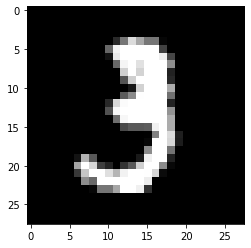

In [3]:
# We can inspect the images using matplotlib:
plt.imshow(X_train[10], cmap="gray")

## The Discriminator

First we will create a discriminator, which will learn how to distinguish real images from synthetic images.

Our discriminator will have two convolutional layers of 64 filters each, a convolutional window (kernel) of 3, and a stride of 2. The output layer uses a sigmoidal activation function to perform binary classification (real image or fake image), minimizing the binary cross entropy loss function.

In [4]:
class Discriminator():
    """
    The GAN's discriminator
    """
    
    def __init__(
        self, 
        filters=64,
        kernel=(3, 3),
        strides=(2, 2),
        padding="same", 
        optimizer=Adam(),
        metrics=["accuracy"], 
        activation="sigmoid", 
        input_shape=(28, 28, 1),
        loss="binary_crossentropy",
    ):
        """
        Parameters
        ----------
        loss : string (default: "binary_crossentropy")
            String (name of objective function), objective function or
            `tf.keras.losses.Loss` instance.

        kernel : tuple (default: (3,3))
            Specifies the height & width of the 2D convolutional window.

        strides : tuple (default: (2, 2))
            The strides of the convolution along the height & width.
                        
        filters : integer (default: 64)
            The dimensionality of the output space.
            
        padding : string, one of "valid" or "same" (default: "same")
            One of "valid" or "same" (case-insensitive). 
            "valid" means no padding. "same" results in padding evenly
            to the left/right or up/down of the input such that output
            has the same height/width dimension as the input.

        optimizer : keras.optimizer (default: Adam())
            String (name of optimizer) or optimizer instance.
            See `tf.keras.optimizers`.

        metrics : list of string (default: ["accuracy"])
            List of metrics to be evaluated by the model during training
            and testing. Each of this can be a string
            (name of a built-in function), function or a
            `tf.keras.metrics.Metric` instance.
            
        activation : string (default: "sigmoid")
            Activation function to use. See `keras.activations`
            
        input_shape : tuple (default: (28, 28, 1))
            The input shape of the data in pixels.
        """
        self.loss = loss
        self.kernel = kernel
        self.strides = strides
        self.filters = filters
        self.padding = padding
        self.metrics = metrics
        self.optimizer = optimizer
        self.activation = activation
        self.input_shape = input_shape
        
        self.build()
        
    def build(self):
        """
        Build the model architecture
        """
        self.model = Sequential()
        self.model.add(Conv2D(
            self.filters,
            self.kernel,
            strides=self.strides,
            padding=self.padding, 
            input_shape=self.input_shape
        ))
        self.model.add(ReLU())
        self.model.add(Dropout(0.4))
        self.model.add(Conv2D(
            self.filters,
            self.kernel,
            strides=self.strides,
            padding=self.padding
        ))
        self.model.add(ReLU())
        self.model.add(Dropout(0.4))
        self.model.add(Flatten())
        self.model.add(Dense(1, activation=self.activation))

        self.model.compile(
            loss=self.loss, 
            optimizer=self.optimizer, 
            metrics=self.metrics
        )

    def make_fakes(self, n_samples):
        """
        Generate uniform random numbers in [0,1], 
        reshape into a batch of grayscale images,
        generate fake class labels (0), and return the
        synthetic data
        """
        X = rand(28 * 28 * n_samples)
        X = X.reshape((n_samples, 28, 28, 1))
        y = np.zeros((n_samples, 1))
        return X, y 
    
    def get_real(self, X, n_samples):
        """
        Take the training dataset as an argument and select
        a random subsample of images; 
        Return class labels of 1 for each sample
        to indicate real images.
        """
        ix = randint(0, X.shape[0], n_samples)
        X_test = X[ix]
        y_test = np.ones((n_samples, 1))
        return X_test, y_test
    
    def train(self, X, n_epochs=100, n_batch=256):
        """
        Loop over the training data, iteratively updating
        the discriminator on real samples, generating fake samples,
        updating the discriminator on the fakes, and summarizing
        the model's performance
        """
        half_batch = int(n_batch / 2)
        for i in range(n_epochs):
            X_real, y_real = self.get_real(X, half_batch)
            _, real_acc = self.model.train_on_batch(X_real, y_real)
            X_fake, y_fake = self.make_fakes(half_batch)
            _, fake_acc = self.model.train_on_batch(X_fake, y_fake)
            print("Iteration {}: real={} fake={}".format(
                i+1, real_acc*100, fake_acc*100
            ))

In [5]:
discriminator = Discriminator()
discriminator.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [6]:
discriminator.train(X_train, n_epochs=25)

Iteration 1: real=79.6875 fake=3.125
Iteration 2: real=99.21875 fake=31.25
Iteration 3: real=99.21875 fake=89.84375
Iteration 4: real=96.875 fake=100.0
Iteration 5: real=93.75 fake=100.0
Iteration 6: real=89.84375 fake=100.0
Iteration 7: real=79.6875 fake=100.0
Iteration 8: real=79.6875 fake=100.0
Iteration 9: real=89.0625 fake=100.0
Iteration 10: real=91.40625 fake=100.0
Iteration 11: real=92.96875 fake=100.0
Iteration 12: real=94.53125 fake=100.0
Iteration 13: real=98.4375 fake=100.0
Iteration 14: real=98.4375 fake=100.0
Iteration 15: real=100.0 fake=100.0
Iteration 16: real=100.0 fake=100.0
Iteration 17: real=100.0 fake=100.0
Iteration 18: real=100.0 fake=100.0
Iteration 19: real=100.0 fake=100.0
Iteration 20: real=100.0 fake=100.0
Iteration 21: real=100.0 fake=100.0
Iteration 22: real=100.0 fake=100.0
Iteration 23: real=100.0 fake=100.0
Iteration 24: real=100.0 fake=100.0
Iteration 25: real=100.0 fake=100.0


## The Generator

Next we will create a generator, which will learn how to create new "handwritten" digits.

In [7]:
class Generator():
    """
    The GAN's Generator
    """
    def __init__(
        self, 
        kernel=(4, 4),
        strides=(2, 2),
        padding="same", 
        activation="sigmoid", 
        latent_dimensions=100
    ):
        """
        Parameters
        ----------
        kernel : tuple (default: (4,4))
            Specifies the height & width of the 2D convolutional window.

        strides : tuple (default: (2, 2))
            The strides of the convolution along the height & width.
            
        padding : string, one of "valid" or "same" (default: "same")
            One of "valid" or "same" (case-insensitive). 
            "valid" means no padding. "same" results in padding evenly
            to the left/right or up/down of the input such that output
            has the same height/width dimension as the input.
            
        activation : string (default: "sigmoid")
            Activation function to use. See `keras.activations`
            
        latent_dimensions : int (default: 100)
            Number of latent dimensions in the deep learning model
        """
        self.kernel = kernel
        self.strides = strides
        self.padding = padding
        self.activation = activation
        self.latent = latent_dimensions
    
        self.build()
        
    def build(self):
        """
        Construct a Sequential model with a Dense layer capable
        of producing 7x7 images. Iteratively upsample the dimensions
        """
        self.model = Sequential()
        n_nodes = 128 * 7 * 7
        self.model.add(Dense(n_nodes, input_dim=self.latent))
        self.model.add(ReLU())
        self.model.add(Reshape((7, 7, 128)))
        self.model.add(Conv2DTranspose(
            128, 
            self.kernel, 
            strides=self.strides, 
            padding=self.padding
        ))
        self.model.add(ReLU())
        self.model.add(Conv2DTranspose(
            128, 
            self.kernel, 
            strides=self.strides, 
            padding=self.padding
        ))
        self.model.add(ReLU())
        self.model.add(Conv2D(
            1, 
            (7, 7), 
            activation=self.activation, 
            padding=self.padding
        ))
    
    def make_fakes(self, n_samples):
        """
        Generate points in latent space as input for the generator,
        and predict the outputs
        """
        X_input = rand(self.latent * n_samples)
        X_input = X_input.reshape(n_samples, self.latent)
        X = self.model.predict(X_input)
        y = np.zeros((n_samples, 1))
        return X, y


In [8]:
generator = Generator()
generator.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
re_lu_3 (ReLU)               (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
re_lu_4 (ReLU)               (None, 28, 28, 128)      

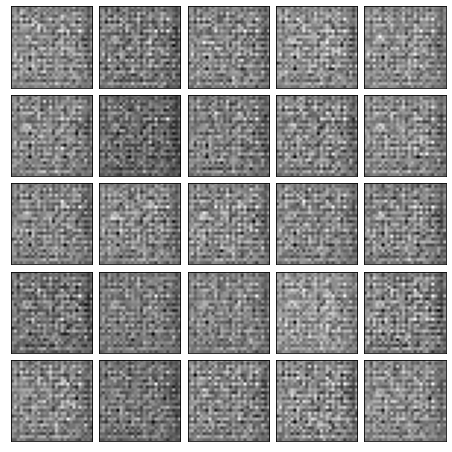

In [9]:
n_fakes = 25
X, _ = generator.make_fakes(n_fakes)

fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(
    fig, 
    111,
    nrows_ncols=(5, 5),
    axes_pad=0.1,
    share_all=True
)

for idx, ax in enumerate(grid):
    ax.imshow(X[idx, :, :, 0], cmap="gray_r")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Build the GAN

In [10]:
class GAN():
    """
    The Generative Adversarial Model
    """
    def __init__(self):
        """
        Instantiate the Discriminator and Generator.
        Make weights in the Discriminator not trainable.
        Connect the two models
        """
        self.latent = 100
        self.generator = Generator()
        self.discriminator = Discriminator()
        self.discriminator.model.trainable = False
        
        self.build()

    def build(self):
        """
        Connect the two models & compile
        """
        self.model = Sequential()
        self.model.add(self.generator.model)
        self.model.add(self.discriminator.model)

        self.model.compile(
            loss=self.discriminator.loss, 
            optimizer=self.discriminator.optimizer
        )
        
    def make_latent_data(self, n_samples):
        """
        Generate points in the latent space and 
        reshape into a batch of inputs for the network
        """
        X = rand(self.latent * n_samples)
        X = X.reshape(n_samples, self.latent)
        return X

    def train(self, X, n_epochs=50, n_batch=256):
        """
        Train the composite model;
        prepare points in latent space as input for the generator,
        create inverted labels for the fake samples,
        update the generator via the discriminator's error
        
        """
        chunks = int(X.shape[0] / n_batch)
        half_batch = int(n_batch / 2)
        
        for epoch in range(n_epochs):
            for chunk in range(chunks):
                X_real, y_real = self.discriminator.get_real(X, half_batch)
                X_fake, y_fake = self.generator.make_fakes(half_batch)
                
                X_train, y_train = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
                d_loss, _ = self.discriminator.model.train_on_batch(X_train, y_train)
                
                X_gan = self.make_latent_data(n_batch)
                y_gan = np.ones((n_batch, 1))
                
                g_loss = self.model.train_on_batch(X_gan, y_gan)
                
                print("Iteration {}, {}/{}, discriminator={}, generator={}".format(
                    epoch + 1, chunk + 1, chunks, d_loss, g_loss
                ))
            if (epoch + 1) % 10 == 0:
                self.evaluate(X, epoch)
        
    def plot(self, examples, epoch, n=10):
        """
        Plot example images as a 10x10 grid, saving the resulting plot
        with a unique filename based on the epoch number.
        """
        for idx in range(n * n):
            plt.subplot(n, n, 1 + idx)
            plt.axis("off")
            plt.imshow(examples[idx, :, :, 0], cmap="gray_r")
        filename = "generated_plot_{}.png".format(epoch + 1)
        plt.savefig(filename)
        plt.close()

    def evaluate(self, X, epoch, n_samples=100):
        """
        Evaluate the discriminator, plot generated images, save generator model
        """
        X_real, y_real = self.discriminator.get_real(X, n_samples)
        _, acc_real = self.discriminator.model.evaluate(X_real, y_real, verbose=0)
        X_fake, y_fake = self.generator.make_fakes(n_samples)
        _, acc_fake = self.discriminator.model.evaluate(X_fake, y_fake, verbose=0)
        print("Accuracy for real: {}, fake: {}".format(
            acc_real*100, acc_fake*100
        ))
        
        filename = "generator_model_{}.h5".format(epoch + 1)
        self.generator.model.save(filename)
        self.plot(X_fake, epoch)

In [11]:
gan = GAN()
gan.model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


In [ ]:
gan.train(X_train)

Iteration 1, 1/234, discriminator=0.7009356021881104, generator=0.7273722290992737
Iteration 1, 2/234, discriminator=0.6716220378875732, generator=0.8025686740875244
Iteration 1, 3/234, discriminator=0.6424407958984375, generator=0.9033490419387817
Iteration 1, 4/234, discriminator=0.6124604940414429, generator=0.9764598608016968
Iteration 1, 5/234, discriminator=0.6151496171951294, generator=0.924962043762207
Iteration 1, 6/234, discriminator=0.6509299278259277, generator=0.753930389881134
Iteration 1, 7/234, discriminator=0.6455612778663635, generator=0.6929723024368286
Iteration 1, 8/234, discriminator=0.6050161123275757, generator=0.6941192150115967
Iteration 1, 9/234, discriminator=0.5478416085243225, generator=0.6982916593551636
Iteration 1, 10/234, discriminator=0.4982050955295563, generator=0.701746940612793
Iteration 1, 11/234, discriminator=0.444122850894928, generator=0.7076754570007324
Iteration 1, 12/234, discriminator=0.3965837359428406, generator=0.7094759345054626
Itera

Iteration 1, 97/234, discriminator=9.849255729932338e-05, generator=8.624088287353516
Iteration 1, 98/234, discriminator=0.00010109283903148025, generator=8.6628999710083
Iteration 1, 99/234, discriminator=0.00010156388452742249, generator=8.667688369750977
Iteration 1, 100/234, discriminator=0.00010123951506102458, generator=8.697490692138672
Iteration 1, 101/234, discriminator=9.87623498076573e-05, generator=8.693941116333008
Iteration 1, 102/234, discriminator=9.130338730756193e-05, generator=8.68398380279541
Iteration 1, 103/234, discriminator=9.451720688957721e-05, generator=8.685216903686523
Iteration 1, 104/234, discriminator=9.117164881899953e-05, generator=8.735945701599121
Iteration 1, 105/234, discriminator=8.774786692811176e-05, generator=8.78676986694336
Iteration 1, 106/234, discriminator=8.773741137702018e-05, generator=8.758774757385254
Iteration 1, 107/234, discriminator=8.440279634669423e-05, generator=8.807352066040039
Iteration 1, 108/234, discriminator=8.1983031122

Iteration 1, 192/234, discriminator=4.135452036280185e-05, generator=9.628028869628906
Iteration 1, 193/234, discriminator=4.077933408552781e-05, generator=9.679931640625
Iteration 1, 194/234, discriminator=3.783838837989606e-05, generator=9.671688079833984
Iteration 1, 195/234, discriminator=3.642146839410998e-05, generator=9.572948455810547
Iteration 1, 196/234, discriminator=4.192005144432187e-05, generator=9.62035083770752
Iteration 1, 197/234, discriminator=3.637900954345241e-05, generator=9.61937141418457
Iteration 1, 198/234, discriminator=3.661949813249521e-05, generator=9.601055145263672
Iteration 1, 199/234, discriminator=3.448524512350559e-05, generator=9.649759292602539
Iteration 1, 200/234, discriminator=4.467890539672226e-05, generator=9.707935333251953
Iteration 1, 201/234, discriminator=3.441275839577429e-05, generator=9.60877799987793
Iteration 1, 202/234, discriminator=3.875156835420057e-05, generator=9.672653198242188
Iteration 1, 203/234, discriminator=3.49577821907

Iteration 2, 53/234, discriminator=2.2923377400729805e-05, generator=10.098949432373047
Iteration 2, 54/234, discriminator=2.29123452299973e-05, generator=10.205143928527832
Iteration 2, 55/234, discriminator=2.1913951059104875e-05, generator=10.115816116333008
Iteration 2, 56/234, discriminator=2.1395579096861184e-05, generator=10.174518585205078
Iteration 2, 57/234, discriminator=2.0276133000152186e-05, generator=10.181644439697266
Iteration 2, 58/234, discriminator=2.2897409508004785e-05, generator=10.18052864074707
Iteration 2, 59/234, discriminator=2.3253614926943555e-05, generator=10.211292266845703
Iteration 2, 60/234, discriminator=2.2514810552820563e-05, generator=10.205460548400879
Iteration 2, 61/234, discriminator=2.0953662897227332e-05, generator=10.199482917785645
Iteration 2, 62/234, discriminator=2.1488041966222227e-05, generator=10.237150192260742
Iteration 2, 63/234, discriminator=2.1833808204974048e-05, generator=10.229249000549316
Iteration 2, 64/234, discriminator=

Iteration 2, 147/234, discriminator=1.9145834812661633e-05, generator=10.22457504272461
Iteration 2, 148/234, discriminator=2.1456944523379207e-05, generator=10.181467056274414
Iteration 2, 149/234, discriminator=2.249593671876937e-05, generator=10.200721740722656
Iteration 2, 150/234, discriminator=2.0581825083354488e-05, generator=10.225471496582031
Iteration 2, 151/234, discriminator=1.9887431335519068e-05, generator=10.208017349243164
Iteration 2, 152/234, discriminator=2.0882645912934095e-05, generator=10.231021881103516
Iteration 2, 153/234, discriminator=2.168840728700161e-05, generator=10.205253601074219
Iteration 2, 154/234, discriminator=7.622072007507086e-05, generator=10.180852890014648
Iteration 2, 155/234, discriminator=2.0035349734826013e-05, generator=10.201628684997559
Iteration 2, 156/234, discriminator=2.14904393942561e-05, generator=10.221872329711914
Iteration 2, 157/234, discriminator=2.0636376575566828e-05, generator=10.281749725341797
Iteration 2, 158/234, discr

Iteration 3, 6/234, discriminator=1.5158707356022205e-05, generator=10.581018447875977
Iteration 3, 7/234, discriminator=1.4451791685132775e-05, generator=10.604055404663086
Iteration 3, 8/234, discriminator=1.3877909623261075e-05, generator=10.60134506225586
Iteration 3, 9/234, discriminator=1.5136227375478484e-05, generator=10.579843521118164
Iteration 3, 10/234, discriminator=1.4461750652117189e-05, generator=10.598169326782227
Iteration 3, 11/234, discriminator=1.4677265426144004e-05, generator=10.616802215576172
Iteration 3, 12/234, discriminator=1.2972221156815067e-05, generator=10.63174057006836
Iteration 3, 13/234, discriminator=1.4987328540883027e-05, generator=10.603609085083008
Iteration 3, 14/234, discriminator=4.195429937681183e-05, generator=10.579933166503906
Iteration 3, 15/234, discriminator=1.3795042832498439e-05, generator=10.57689094543457
Iteration 3, 16/234, discriminator=1.3440458133118227e-05, generator=10.660176277160645
Iteration 3, 17/234, discriminator=1.427

Iteration 3, 100/234, discriminator=5.9787413192680106e-05, generator=10.939888954162598
Iteration 3, 101/234, discriminator=1.0792180546559393e-05, generator=10.951933860778809
Iteration 3, 102/234, discriminator=9.740377208800055e-06, generator=10.977338790893555
Iteration 3, 103/234, discriminator=1.0223566278000362e-05, generator=10.920034408569336
Iteration 3, 104/234, discriminator=1.0956913683912717e-05, generator=10.947980880737305
Iteration 3, 105/234, discriminator=9.301622412749566e-06, generator=11.036012649536133
Iteration 3, 106/234, discriminator=9.813724318519235e-06, generator=10.960723876953125
Iteration 3, 107/234, discriminator=1.0799807569128461e-05, generator=10.970976829528809
Iteration 3, 108/234, discriminator=1.0620524335536174e-05, generator=10.912020683288574
Iteration 3, 109/234, discriminator=9.44797011470655e-06, generator=10.948368072509766
Iteration 3, 110/234, discriminator=8.88549220690038e-06, generator=10.931905746459961
Iteration 3, 111/234, discri

Iteration 3, 194/234, discriminator=9.025258805195335e-06, generator=11.144474983215332
Iteration 3, 195/234, discriminator=9.088838851312175e-06, generator=11.128944396972656
Iteration 3, 196/234, discriminator=8.70443727762904e-06, generator=11.080310821533203
Iteration 3, 197/234, discriminator=8.755514500080608e-06, generator=11.156620025634766
Iteration 3, 198/234, discriminator=8.825727491057478e-06, generator=11.127165794372559
Iteration 3, 199/234, discriminator=8.459028322249651e-06, generator=11.132074356079102
Iteration 3, 200/234, discriminator=1.131069893745007e-05, generator=11.192458152770996
Iteration 3, 201/234, discriminator=8.700611942913383e-06, generator=11.152935028076172
Iteration 3, 202/234, discriminator=8.248138328781351e-06, generator=11.166025161743164
Iteration 3, 203/234, discriminator=9.053339454112574e-05, generator=11.143472671508789
Iteration 3, 204/234, discriminator=8.591330697527155e-06, generator=11.089654922485352
Iteration 3, 205/234, discriminat

Iteration 4, 55/234, discriminator=8.416413038503379e-06, generator=11.316462516784668
Iteration 4, 56/234, discriminator=7.124708645278588e-06, generator=11.29501724243164
Iteration 4, 57/234, discriminator=2.258283166156616e-05, generator=11.381298065185547
Iteration 4, 58/234, discriminator=7.294190709217219e-06, generator=11.301416397094727
Iteration 4, 59/234, discriminator=7.163087047956651e-06, generator=11.366394996643066
Iteration 4, 60/234, discriminator=6.898136234667618e-06, generator=11.354783058166504
Iteration 4, 61/234, discriminator=7.180557076935656e-06, generator=11.3280029296875
Iteration 4, 62/234, discriminator=7.269173693202902e-06, generator=11.361993789672852
Iteration 4, 63/234, discriminator=7.035247108433396e-06, generator=11.328154563903809
Iteration 4, 64/234, discriminator=7.503531833208399e-06, generator=11.313097953796387
Iteration 4, 65/234, discriminator=7.169192031142302e-06, generator=11.392101287841797
Iteration 4, 66/234, discriminator=7.143974471

Iteration 4, 149/234, discriminator=6.636797479586676e-06, generator=11.362373352050781
Iteration 4, 150/234, discriminator=6.7957735154777765e-06, generator=11.3385009765625
Iteration 4, 151/234, discriminator=6.905292138981167e-06, generator=11.369529724121094
Iteration 4, 152/234, discriminator=7.4449953899602406e-06, generator=11.336454391479492
Iteration 4, 153/234, discriminator=7.153639671741985e-06, generator=11.336051940917969
Iteration 4, 154/234, discriminator=6.964860403968487e-06, generator=11.358779907226562
Iteration 4, 155/234, discriminator=6.38613710179925e-06, generator=11.356518745422363
Iteration 4, 156/234, discriminator=6.845069947303273e-06, generator=11.35270881652832
Iteration 4, 157/234, discriminator=6.461539214797085e-06, generator=11.439823150634766
Iteration 4, 158/234, discriminator=6.435461727960501e-06, generator=11.430608749389648
Iteration 4, 159/234, discriminator=7.029925654933322e-06, generator=11.35869026184082
Iteration 4, 160/234, discriminator

Iteration 5, 9/234, discriminator=5.363541276892647e-06, generator=11.638032913208008
Iteration 5, 10/234, discriminator=5.5677951422694605e-06, generator=11.629592895507812
Iteration 5, 11/234, discriminator=5.58551346330205e-06, generator=11.60296630859375
Iteration 5, 12/234, discriminator=5.310022061166819e-06, generator=11.664413452148438
Iteration 5, 13/234, discriminator=4.956841621606145e-06, generator=11.633378982543945
Iteration 5, 14/234, discriminator=5.022307959734462e-06, generator=11.605131149291992
Iteration 5, 15/234, discriminator=5.566993422689848e-06, generator=11.59986400604248
Iteration 5, 16/234, discriminator=5.36335301148938e-06, generator=11.634377479553223
Iteration 5, 17/234, discriminator=5.1839615480275825e-06, generator=11.622060775756836
Iteration 5, 18/234, discriminator=5.050766503700288e-06, generator=11.616043090820312
Iteration 5, 19/234, discriminator=5.584734935837332e-06, generator=11.70338249206543
Iteration 5, 20/234, discriminator=5.1894994612

Iteration 5, 104/234, discriminator=4.155316673859488e-06, generator=11.82187271118164
Iteration 5, 105/234, discriminator=4.24567588197533e-06, generator=11.758625984191895
Iteration 5, 106/234, discriminator=4.28970542998286e-06, generator=11.840719223022461
Iteration 5, 107/234, discriminator=4.25344751420198e-06, generator=11.805485725402832
Iteration 5, 108/234, discriminator=3.761194875551155e-06, generator=11.778970718383789
Iteration 5, 109/234, discriminator=4.186233127256855e-06, generator=11.871803283691406
Iteration 5, 110/234, discriminator=3.7700392567785457e-06, generator=11.810662269592285
Iteration 5, 111/234, discriminator=5.201760359341279e-06, generator=11.801435470581055
Iteration 5, 112/234, discriminator=6.581523848581128e-06, generator=11.87850284576416
Iteration 5, 113/234, discriminator=4.1287885323981754e-06, generator=11.848039627075195
Iteration 5, 114/234, discriminator=4.438174073584378e-06, generator=11.809797286987305
Iteration 5, 115/234, discriminator

Iteration 5, 198/234, discriminator=4.254025952832308e-06, generator=11.951469421386719
Iteration 5, 199/234, discriminator=4.437551069713663e-06, generator=11.92387580871582
Iteration 5, 200/234, discriminator=3.801544607995311e-06, generator=11.960350036621094
Iteration 5, 201/234, discriminator=3.7803647501277737e-06, generator=11.914521217346191
Iteration 5, 202/234, discriminator=3.97291387344012e-06, generator=11.963050842285156
Iteration 5, 203/234, discriminator=4.0937256926554255e-06, generator=11.876489639282227
Iteration 5, 204/234, discriminator=3.587095307011623e-06, generator=11.903966903686523
Iteration 5, 205/234, discriminator=4.096403245057445e-06, generator=11.90514087677002
Iteration 5, 206/234, discriminator=4.1906105252564885e-06, generator=11.973715782165527
Iteration 5, 207/234, discriminator=3.773650860239286e-06, generator=11.880495071411133
Iteration 5, 208/234, discriminator=3.5920777463616105e-06, generator=11.981847763061523
Iteration 5, 209/234, discrimin

Iteration 6, 58/234, discriminator=3.474096956779249e-06, generator=12.028977394104004
Iteration 6, 59/234, discriminator=3.387674951227382e-06, generator=12.026715278625488
Iteration 6, 60/234, discriminator=3.5272291825094726e-06, generator=12.046509742736816
Iteration 6, 61/234, discriminator=3.241039848944638e-06, generator=12.001419067382812
Iteration 6, 62/234, discriminator=4.099479156138841e-06, generator=11.944721221923828
Iteration 6, 63/234, discriminator=3.4802196751115844e-06, generator=11.97677230834961
Iteration 6, 64/234, discriminator=3.2598643429082585e-06, generator=12.002103805541992
Iteration 6, 65/234, discriminator=3.2822595130710397e-06, generator=12.044347763061523
Iteration 6, 66/234, discriminator=3.8666603359160945e-06, generator=12.013677597045898
Iteration 6, 67/234, discriminator=3.3214319046237506e-06, generator=12.063783645629883
Iteration 6, 68/234, discriminator=3.5365105759410653e-06, generator=12.059255599975586
Iteration 6, 69/234, discriminator=3.

Iteration 6, 152/234, discriminator=3.0590692858822877e-06, generator=12.142518997192383
Iteration 6, 153/234, discriminator=3.0811786473350367e-06, generator=12.25281810760498
Iteration 6, 154/234, discriminator=3.204814674973022e-06, generator=12.241381645202637
Iteration 6, 155/234, discriminator=2.944615289379726e-06, generator=12.204536437988281
Iteration 6, 156/234, discriminator=2.858123025362147e-06, generator=12.159513473510742
Iteration 6, 157/234, discriminator=3.2325435768143507e-06, generator=12.220476150512695
Iteration 6, 158/234, discriminator=9.93965586530976e-05, generator=12.230058670043945
Iteration 6, 159/234, discriminator=2.690704150154488e-06, generator=12.205467224121094
Iteration 6, 160/234, discriminator=2.9888358312746277e-06, generator=12.264578819274902
Iteration 6, 161/234, discriminator=2.8071988253941527e-06, generator=12.127359390258789
Iteration 6, 162/234, discriminator=2.7319922537571983e-06, generator=12.10495662689209
Iteration 6, 163/234, discrim

Iteration 7, 12/234, discriminator=4.2978826968465e-06, generator=12.29826545715332
Iteration 7, 13/234, discriminator=2.9622094643855235e-06, generator=12.379457473754883
Iteration 7, 14/234, discriminator=2.6251641429553274e-06, generator=12.338861465454102
Iteration 7, 15/234, discriminator=2.595901378299459e-06, generator=12.24252700805664
Iteration 7, 16/234, discriminator=2.657105369507917e-06, generator=12.32728385925293
Iteration 7, 17/234, discriminator=2.7326113922754303e-06, generator=12.361945152282715
Iteration 7, 18/234, discriminator=2.5951815132430056e-06, generator=12.285615921020508
Iteration 7, 19/234, discriminator=2.690313067432726e-06, generator=12.308775901794434
Iteration 7, 20/234, discriminator=3.001222694365424e-06, generator=12.309322357177734
Iteration 7, 21/234, discriminator=2.5434951567149255e-06, generator=12.28107738494873
Iteration 7, 22/234, discriminator=2.91620267489634e-06, generator=12.315265655517578
Iteration 7, 23/234, discriminator=2.80908307

Iteration 7, 106/234, discriminator=2.3946772671479266e-06, generator=12.43249225616455
Iteration 7, 107/234, discriminator=2.273895006510429e-06, generator=12.39201545715332
Iteration 7, 108/234, discriminator=2.4951802970463177e-06, generator=12.417713165283203
Iteration 7, 109/234, discriminator=2.4348109946004115e-06, generator=12.416891098022461
Iteration 7, 110/234, discriminator=2.381749709456926e-06, generator=12.404033660888672
Iteration 7, 111/234, discriminator=2.219565203631646e-06, generator=12.464019775390625
Iteration 7, 112/234, discriminator=2.349724582018098e-06, generator=12.524471282958984
Iteration 7, 113/234, discriminator=2.513902472855989e-06, generator=12.530282020568848
Iteration 7, 114/234, discriminator=2.3352267817244865e-06, generator=12.416692733764648
Iteration 7, 115/234, discriminator=2.149676902263309e-06, generator=12.449633598327637
Iteration 7, 116/234, discriminator=2.2275239643931855e-06, generator=12.431985855102539
Iteration 7, 117/234, discrim

Iteration 7, 199/234, discriminator=2.3672737370361574e-06, generator=12.424427032470703
Iteration 7, 200/234, discriminator=2.4029764063016046e-06, generator=12.482355117797852
Iteration 7, 201/234, discriminator=2.0371676328068133e-06, generator=12.476781845092773
Iteration 7, 202/234, discriminator=2.1821781501785154e-06, generator=12.536092758178711
Iteration 7, 203/234, discriminator=1.9600197447289247e-06, generator=12.4741792678833
Iteration 7, 204/234, discriminator=1.95326629182091e-06, generator=12.537261009216309
Iteration 7, 205/234, discriminator=1.984451500902651e-06, generator=12.528135299682617
Iteration 7, 206/234, discriminator=1.9873859855579212e-06, generator=12.50129222869873
Iteration 7, 207/234, discriminator=2.013852508753189e-06, generator=12.60727310180664
Iteration 7, 208/234, discriminator=2.2252320377447177e-06, generator=12.522881507873535
Iteration 7, 209/234, discriminator=2.157376911782194e-06, generator=12.468111038208008
Iteration 7, 210/234, discrimi

Iteration 8, 59/234, discriminator=2.144955942640081e-06, generator=12.640562057495117
Iteration 8, 60/234, discriminator=2.0841996501985705e-06, generator=12.597917556762695
Iteration 8, 61/234, discriminator=2.0371210212033475e-06, generator=12.553913116455078
Iteration 8, 62/234, discriminator=2.2403842194762547e-06, generator=12.594053268432617
Iteration 8, 63/234, discriminator=2.2301001081359573e-06, generator=12.544716835021973
Iteration 8, 64/234, discriminator=2.163744738936657e-06, generator=12.519704818725586
Iteration 8, 65/234, discriminator=2.1342357285902835e-06, generator=12.511292457580566
Iteration 8, 66/234, discriminator=2.0360057533252984e-06, generator=12.499567031860352
Iteration 8, 67/234, discriminator=2.1645580545737175e-06, generator=12.47081184387207
Iteration 8, 68/234, discriminator=2.1962860046187416e-06, generator=12.519198417663574
Iteration 8, 69/234, discriminator=2.1023770386818796e-06, generator=12.489113807678223
Iteration 8, 70/234, discriminator=

Iteration 8, 153/234, discriminator=1.9576445993152447e-06, generator=12.66090202331543
Iteration 8, 154/234, discriminator=1.911171011670376e-06, generator=12.673639297485352
Iteration 8, 155/234, discriminator=1.6742961861382355e-06, generator=12.593283653259277
Iteration 8, 156/234, discriminator=1.802707402021042e-06, generator=12.61963176727295
Iteration 8, 157/234, discriminator=1.99137639356195e-06, generator=12.614952087402344
Iteration 8, 158/234, discriminator=1.7217316781170666e-06, generator=12.668256759643555
Iteration 8, 159/234, discriminator=1.9915660232072696e-06, generator=12.626740455627441
Iteration 8, 160/234, discriminator=2.052519221251714e-06, generator=12.617496490478516
Iteration 8, 161/234, discriminator=1.9087135569861857e-06, generator=12.599076271057129
Iteration 8, 162/234, discriminator=1.8877112779591698e-06, generator=12.708362579345703
Iteration 8, 163/234, discriminator=1.8239372820971766e-06, generator=12.737663269042969
Iteration 8, 164/234, discri

Iteration 9, 12/234, discriminator=1.6825242710183375e-06, generator=12.796903610229492
Iteration 9, 13/234, discriminator=1.545862915008911e-06, generator=12.899860382080078
Iteration 9, 14/234, discriminator=1.6812713283798075e-06, generator=12.775775909423828
Iteration 9, 15/234, discriminator=1.6261967630271101e-06, generator=12.8401460647583
Iteration 9, 16/234, discriminator=1.523102127976017e-06, generator=12.814847946166992
Iteration 9, 17/234, discriminator=1.5730552149761934e-06, generator=12.78980827331543
Iteration 9, 18/234, discriminator=1.676672354733455e-06, generator=12.817262649536133
Iteration 9, 19/234, discriminator=1.48231833918544e-06, generator=12.822486877441406
Iteration 9, 20/234, discriminator=1.6757065850470099e-06, generator=12.861590385437012
Iteration 9, 21/234, discriminator=1.610709773558483e-06, generator=12.803923606872559
Iteration 9, 22/234, discriminator=1.6374332290070015e-06, generator=12.793903350830078
Iteration 9, 23/234, discriminator=1.6703

Iteration 9, 106/234, discriminator=1.3404035144048976e-06, generator=13.018545150756836
Iteration 9, 107/234, discriminator=1.3645051240018802e-06, generator=12.9342041015625
Iteration 9, 108/234, discriminator=1.4454371921601705e-06, generator=12.992386817932129
Iteration 9, 109/234, discriminator=1.37899701257993e-06, generator=12.983009338378906
Iteration 9, 110/234, discriminator=1.5478624391107587e-06, generator=13.005706787109375
Iteration 9, 111/234, discriminator=1.6090577901195502e-06, generator=12.996963500976562
Iteration 9, 112/234, discriminator=1.2927066563861445e-06, generator=12.927587509155273
Iteration 9, 113/234, discriminator=1.767772459970729e-06, generator=12.992876052856445
Iteration 9, 114/234, discriminator=1.3996029792906484e-06, generator=13.01688003540039
Iteration 9, 115/234, discriminator=1.473497718507133e-06, generator=13.003280639648438
Iteration 9, 116/234, discriminator=1.4306285720522283e-06, generator=12.953973770141602
Iteration 9, 117/234, discri

Iteration 9, 199/234, discriminator=1.387058887303283e-06, generator=13.027811050415039
Iteration 9, 200/234, discriminator=1.192236481983855e-06, generator=13.02409553527832
Iteration 9, 201/234, discriminator=1.3297635632625315e-06, generator=12.971168518066406
Iteration 9, 202/234, discriminator=1.2526263617473887e-06, generator=12.967264175415039
Iteration 9, 203/234, discriminator=1.2825983048969647e-06, generator=12.999757766723633
Iteration 9, 204/234, discriminator=1.3220056871432462e-06, generator=12.986654281616211
Iteration 9, 205/234, discriminator=1.3932542515249224e-06, generator=12.993427276611328
Iteration 9, 206/234, discriminator=1.3454657619149657e-06, generator=12.966846466064453
Iteration 9, 207/234, discriminator=1.3421665698842844e-06, generator=13.021051406860352
Iteration 9, 208/234, discriminator=1.3638270957017085e-06, generator=13.019530296325684
Iteration 9, 209/234, discriminator=1.4922974287401303e-06, generator=13.016168594360352
Iteration 9, 210/234, di

Iteration 10, 58/234, discriminator=1.3078274605504703e-06, generator=13.061290740966797
Iteration 10, 59/234, discriminator=1.1593881481530843e-06, generator=13.136829376220703
Iteration 10, 60/234, discriminator=1.2297959983698092e-06, generator=13.185721397399902
Iteration 10, 61/234, discriminator=1.2593818610184826e-06, generator=13.050138473510742
Iteration 10, 62/234, discriminator=1.280590595342801e-06, generator=13.132721900939941
Iteration 10, 63/234, discriminator=1.2099192190362373e-06, generator=13.036999702453613
Iteration 10, 64/234, discriminator=1.3602747230834211e-06, generator=13.114997863769531
Iteration 10, 65/234, discriminator=1.1522846534717246e-06, generator=13.09911823272705
Iteration 10, 66/234, discriminator=1.283027813769877e-06, generator=13.144256591796875
Iteration 10, 67/234, discriminator=1.3685647672900814e-06, generator=13.074731826782227
Iteration 10, 68/234, discriminator=1.1645088306977414e-06, generator=13.092931747436523
Iteration 10, 69/234, di

Iteration 10, 150/234, discriminator=1.0813333801706904e-06, generator=13.218053817749023
Iteration 10, 151/234, discriminator=1.0431140253785998e-06, generator=13.19887924194336
Iteration 10, 152/234, discriminator=1.0262099294777727e-06, generator=13.211773872375488
Iteration 10, 153/234, discriminator=1.089682882593479e-06, generator=13.214064598083496
Iteration 10, 154/234, discriminator=1.0488862471902394e-06, generator=13.147047996520996
Iteration 10, 155/234, discriminator=1.0751639365480514e-06, generator=13.219766616821289
Iteration 10, 156/234, discriminator=1.1257926644248073e-06, generator=13.267311096191406
Iteration 10, 157/234, discriminator=1.0630092219798826e-06, generator=13.247817993164062
Iteration 10, 158/234, discriminator=1.0711858067224966e-06, generator=13.246931076049805
Iteration 10, 159/234, discriminator=1.1701492894644616e-06, generator=13.170514106750488
Iteration 10, 160/234, discriminator=1.1520182852109428e-06, generator=13.211806297302246
Iteration 10

Iteration 11, 8/234, discriminator=1.0917053714365466e-06, generator=13.292610168457031
Iteration 11, 9/234, discriminator=9.866289474302903e-07, generator=13.193798065185547
Iteration 11, 10/234, discriminator=1.0967808066197904e-06, generator=13.335153579711914
Iteration 11, 11/234, discriminator=9.72595444181934e-07, generator=13.287803649902344
Iteration 11, 12/234, discriminator=1.150922116721631e-06, generator=13.20901107788086
Iteration 11, 13/234, discriminator=9.871290558294277e-07, generator=13.228023529052734
Iteration 11, 14/234, discriminator=9.624072845326737e-07, generator=13.244413375854492
Iteration 11, 15/234, discriminator=1.003401280286198e-06, generator=13.29166316986084
Iteration 11, 16/234, discriminator=9.437389962840825e-07, generator=13.251086235046387
Iteration 11, 17/234, discriminator=1.047192881742376e-06, generator=13.331598281860352
Iteration 11, 18/234, discriminator=1.089612624127767e-06, generator=13.286789894104004
Iteration 11, 19/234, discriminator

Iteration 11, 102/234, discriminator=9.61884438765992e-07, generator=13.329535484313965
Iteration 11, 103/234, discriminator=7.708850944254664e-07, generator=13.394253730773926
Iteration 11, 104/234, discriminator=1.0145587339138729e-06, generator=13.392848014831543
Iteration 11, 105/234, discriminator=8.991367508315307e-07, generator=13.410375595092773
Iteration 11, 106/234, discriminator=1.0063148465633276e-06, generator=13.284414291381836
Iteration 11, 107/234, discriminator=9.191404046759999e-07, generator=13.386861801147461
Iteration 11, 108/234, discriminator=9.792454420676222e-07, generator=13.371831893920898
Iteration 11, 109/234, discriminator=8.068856800491631e-07, generator=13.297992706298828
Iteration 11, 110/234, discriminator=8.769115993345622e-07, generator=13.425936698913574
Iteration 11, 111/234, discriminator=9.449457820664975e-07, generator=13.28995132446289
Iteration 11, 112/234, discriminator=1.0672056305338629e-06, generator=13.348047256469727
Iteration 11, 113/23

Iteration 11, 195/234, discriminator=8.533448294656409e-07, generator=13.500007629394531
Iteration 11, 196/234, discriminator=9.010635722006555e-07, generator=13.433971405029297
Iteration 11, 197/234, discriminator=8.186745503735438e-07, generator=13.434261322021484
Iteration 11, 198/234, discriminator=8.518723007000517e-07, generator=13.517068862915039
Iteration 11, 199/234, discriminator=9.054280667442072e-07, generator=13.46575927734375
Iteration 11, 200/234, discriminator=1.067336256710405e-06, generator=13.510855674743652
Iteration 11, 201/234, discriminator=8.426936801697593e-07, generator=13.475530624389648
Iteration 11, 202/234, discriminator=8.06206571724033e-07, generator=13.480754852294922
Iteration 11, 203/234, discriminator=8.382000942219747e-07, generator=13.535686492919922
Iteration 11, 204/234, discriminator=8.423036206295365e-07, generator=13.550986289978027
Iteration 11, 205/234, discriminator=7.862922757340129e-07, generator=13.490201950073242
Iteration 11, 206/234, 

Iteration 12, 55/234, discriminator=7.883120360929752e-07, generator=13.592300415039062
Iteration 12, 56/234, discriminator=6.747512770743924e-07, generator=13.5117826461792
Iteration 12, 57/234, discriminator=7.481797865693807e-07, generator=13.58426570892334
Iteration 12, 58/234, discriminator=7.095603677953477e-07, generator=13.577627182006836
Iteration 12, 59/234, discriminator=7.06670959971234e-07, generator=13.576787948608398
Iteration 12, 60/234, discriminator=7.444594416483596e-07, generator=13.572540283203125
Iteration 12, 61/234, discriminator=8.576740242460801e-07, generator=13.554588317871094
Iteration 12, 62/234, discriminator=7.08167249285907e-07, generator=13.667227745056152
Iteration 12, 63/234, discriminator=8.052933822000341e-07, generator=13.597208976745605
Iteration 12, 64/234, discriminator=8.219044502766337e-07, generator=13.619684219360352
Iteration 12, 65/234, discriminator=7.499431831092807e-07, generator=13.600427627563477
Iteration 12, 66/234, discriminator=7

Iteration 12, 148/234, discriminator=7.027888955235539e-07, generator=13.686240196228027
Iteration 12, 149/234, discriminator=7.045018151075055e-07, generator=13.713717460632324
Iteration 12, 150/234, discriminator=6.785204504922149e-07, generator=13.707535743713379
Iteration 12, 151/234, discriminator=6.442992344091181e-07, generator=13.656424522399902
Iteration 12, 152/234, discriminator=6.878337899252074e-07, generator=13.646684646606445
Iteration 12, 153/234, discriminator=6.718354370605084e-07, generator=13.692008972167969
Iteration 12, 154/234, discriminator=6.2263791278383e-07, generator=13.683961868286133
Iteration 12, 155/234, discriminator=6.626075901294826e-07, generator=13.676644325256348
Iteration 12, 156/234, discriminator=6.506896852442878e-07, generator=13.695428848266602
Iteration 12, 157/234, discriminator=6.489829047495732e-07, generator=13.737150192260742
Iteration 12, 158/234, discriminator=6.96305392011709e-07, generator=13.700183868408203
Iteration 12, 159/234, d

Iteration 13, 7/234, discriminator=5.76759532577853e-07, generator=13.819275856018066
Iteration 13, 8/234, discriminator=6.905821692271275e-07, generator=13.73797607421875
Iteration 13, 9/234, discriminator=6.317775387287838e-07, generator=13.761332511901855
Iteration 13, 10/234, discriminator=6.166153525555274e-07, generator=13.779860496520996
Iteration 13, 11/234, discriminator=5.715445468013058e-07, generator=13.82762336730957
Iteration 13, 12/234, discriminator=6.602263624699845e-07, generator=13.765832901000977
Iteration 13, 13/234, discriminator=6.580015678991913e-07, generator=13.835309982299805
Iteration 13, 14/234, discriminator=5.937238256592536e-07, generator=13.832322120666504
Iteration 13, 15/234, discriminator=6.948606028345239e-07, generator=13.850711822509766
Iteration 13, 16/234, discriminator=5.494391643878771e-07, generator=13.878596305847168
Iteration 13, 17/234, discriminator=5.954007065156475e-07, generator=13.785478591918945
Iteration 13, 18/234, discriminator=6.

Iteration 13, 101/234, discriminator=5.896738457522588e-07, generator=13.863357543945312
Iteration 13, 102/234, discriminator=6.161783971947443e-07, generator=13.886295318603516
Iteration 13, 103/234, discriminator=5.195984158490319e-07, generator=13.913619995117188
Iteration 13, 104/234, discriminator=5.505257831828203e-07, generator=13.967153549194336
Iteration 13, 105/234, discriminator=5.503502507053781e-07, generator=13.894723892211914
Iteration 13, 106/234, discriminator=5.544192163142725e-07, generator=13.80183219909668
Iteration 13, 107/234, discriminator=5.756201062467881e-07, generator=13.920650482177734
Iteration 13, 108/234, discriminator=5.276492629491258e-07, generator=13.927885055541992
Iteration 13, 109/234, discriminator=6.052900971553754e-07, generator=13.879378318786621
Iteration 13, 110/234, discriminator=5.135754008733784e-07, generator=13.886333465576172
Iteration 13, 111/234, discriminator=5.093437493997044e-07, generator=13.884639739990234
Iteration 13, 112/234,

Iteration 13, 194/234, discriminator=5.242787892711931e-07, generator=13.975433349609375
Iteration 13, 195/234, discriminator=5.310181450113305e-07, generator=14.002287864685059
Iteration 13, 196/234, discriminator=4.6095294692349853e-07, generator=13.984764099121094
Iteration 13, 197/234, discriminator=5.966177241134574e-07, generator=14.071952819824219
Iteration 13, 198/234, discriminator=1.55044858729525e-06, generator=13.98594856262207
Iteration 13, 199/234, discriminator=4.899221721643698e-07, generator=14.017623901367188
Iteration 13, 200/234, discriminator=4.868792871093319e-07, generator=13.936969757080078
Iteration 13, 201/234, discriminator=5.18275612648722e-07, generator=14.010282516479492
Iteration 13, 202/234, discriminator=5.008564585295971e-07, generator=13.99671745300293
Iteration 13, 203/234, discriminator=5.832036436004273e-07, generator=13.947808265686035
Iteration 13, 204/234, discriminator=4.805501134796941e-07, generator=13.97053337097168
Iteration 13, 205/234, di

Iteration 14, 54/234, discriminator=4.565265498968074e-07, generator=14.101990699768066
Iteration 14, 55/234, discriminator=5.153054871698259e-07, generator=13.966893196105957
Iteration 14, 56/234, discriminator=4.824260599889385e-07, generator=14.04265022277832
Iteration 14, 57/234, discriminator=4.330016167841677e-07, generator=14.061044692993164
Iteration 14, 58/234, discriminator=4.557156216833391e-07, generator=14.029594421386719
Iteration 14, 59/234, discriminator=5.209635105529742e-07, generator=14.001441955566406
Iteration 14, 60/234, discriminator=5.106438720758888e-07, generator=14.045978546142578
Iteration 14, 61/234, discriminator=4.790830416823155e-07, generator=14.026487350463867
Iteration 14, 62/234, discriminator=4.6785572749286075e-07, generator=14.014198303222656
Iteration 14, 63/234, discriminator=4.639757662516786e-07, generator=14.105923652648926
Iteration 14, 64/234, discriminator=4.808280209545046e-07, generator=14.104220390319824
Iteration 14, 65/234, discrimina

Iteration 14, 147/234, discriminator=4.474069896787114e-07, generator=14.163899421691895
Iteration 14, 148/234, discriminator=4.809692200069549e-07, generator=14.173517227172852
Iteration 14, 149/234, discriminator=4.2320644411120156e-07, generator=14.08875846862793
Iteration 14, 150/234, discriminator=4.878974095845479e-07, generator=14.177626609802246
Iteration 14, 151/234, discriminator=4.538645157481369e-07, generator=14.140487670898438
Iteration 14, 152/234, discriminator=4.2084587903445936e-07, generator=14.261642456054688
Iteration 14, 153/234, discriminator=4.5125750602892367e-07, generator=14.164649963378906
Iteration 14, 154/234, discriminator=4.3705898633561446e-07, generator=14.11898136138916
Iteration 14, 155/234, discriminator=4.1680988260850427e-07, generator=14.219770431518555
Iteration 14, 156/234, discriminator=3.9479249380747206e-07, generator=14.17071533203125
Iteration 14, 157/234, discriminator=4.2220142404403305e-07, generator=14.188796997070312
Iteration 14, 158

Iteration 15, 5/234, discriminator=3.8429953974628006e-07, generator=14.239704132080078
Iteration 15, 6/234, discriminator=3.860308197545237e-07, generator=14.214595794677734
Iteration 15, 7/234, discriminator=3.9433376741726534e-07, generator=14.190089225769043
Iteration 15, 8/234, discriminator=4.5652592461919994e-07, generator=14.220151901245117
Iteration 15, 9/234, discriminator=3.916209436738427e-07, generator=14.23056411743164
Iteration 15, 10/234, discriminator=4.5812649318577314e-07, generator=14.234400749206543
Iteration 15, 11/234, discriminator=3.7215068005025387e-07, generator=14.204744338989258
Iteration 15, 12/234, discriminator=4.298754276987893e-07, generator=14.22947883605957
Iteration 15, 13/234, discriminator=3.907539962710871e-07, generator=14.304544448852539
Iteration 15, 14/234, discriminator=4.050642132824578e-07, generator=14.256570816040039
Iteration 15, 15/234, discriminator=4.593853475398646e-07, generator=14.312068939208984
Iteration 15, 16/234, discriminato

Iteration 15, 98/234, discriminator=4.022968482786382e-07, generator=14.31179428100586
Iteration 15, 99/234, discriminator=3.658597620415094e-07, generator=14.272229194641113
Iteration 15, 100/234, discriminator=3.7467975744220894e-07, generator=14.28488540649414
Iteration 15, 101/234, discriminator=7.052433943499636e-07, generator=14.315095901489258
Iteration 15, 102/234, discriminator=3.2422039453194884e-07, generator=14.394973754882812
Iteration 15, 103/234, discriminator=3.6998221730755176e-07, generator=14.312887191772461
Iteration 15, 104/234, discriminator=4.201593242214585e-07, generator=14.313069343566895
Iteration 15, 105/234, discriminator=3.9642537785766763e-07, generator=14.322423934936523
Iteration 15, 106/234, discriminator=3.636016572272638e-07, generator=14.384162902832031
Iteration 15, 107/234, discriminator=3.933711809622764e-07, generator=14.30239200592041
Iteration 15, 108/234, discriminator=3.860512265418947e-07, generator=14.343108177185059
Iteration 15, 109/234,

Iteration 15, 190/234, discriminator=3.391488689885591e-07, generator=14.447378158569336
Iteration 15, 191/234, discriminator=3.848015808216587e-07, generator=14.332199096679688
Iteration 15, 192/234, discriminator=3.122355565210455e-07, generator=14.342157363891602
Iteration 15, 193/234, discriminator=3.5401598097450915e-07, generator=14.397241592407227
Iteration 15, 194/234, discriminator=3.665292069854331e-07, generator=14.456236839294434
Iteration 15, 195/234, discriminator=3.467008298230212e-07, generator=14.402210235595703
Iteration 15, 196/234, discriminator=3.4477528743082075e-07, generator=14.420476913452148
Iteration 15, 197/234, discriminator=3.224321858397161e-07, generator=14.430875778198242
Iteration 15, 198/234, discriminator=3.5328093872522004e-07, generator=14.353740692138672
Iteration 15, 199/234, discriminator=3.436294377934246e-07, generator=14.372326850891113
Iteration 15, 200/234, discriminator=3.6306170159150497e-07, generator=14.418604850769043
Iteration 15, 201

Iteration 16, 49/234, discriminator=2.8122726689616684e-06, generator=14.45849609375
Iteration 16, 50/234, discriminator=3.4765548662107904e-07, generator=14.439631462097168
Iteration 16, 51/234, discriminator=3.313299998808361e-07, generator=14.348976135253906
Iteration 16, 52/234, discriminator=3.5514813134795986e-07, generator=14.41314697265625
Iteration 16, 53/234, discriminator=3.2270602901007805e-07, generator=14.400288581848145
Iteration 16, 54/234, discriminator=3.4229216794301465e-07, generator=14.447979927062988
Iteration 16, 55/234, discriminator=3.595930309074902e-07, generator=14.407159805297852
Iteration 16, 56/234, discriminator=3.401002857117419e-07, generator=14.362597465515137
Iteration 16, 57/234, discriminator=3.047383358989464e-07, generator=14.432602882385254
Iteration 16, 58/234, discriminator=3.2846207886905177e-07, generator=14.433900833129883
Iteration 16, 59/234, discriminator=3.577997347292694e-07, generator=14.390933990478516
Iteration 16, 60/234, discrimin

Iteration 16, 142/234, discriminator=3.5344510251889005e-07, generator=14.452472686767578
Iteration 16, 143/234, discriminator=2.721236000979843e-07, generator=14.469715118408203
Iteration 16, 144/234, discriminator=3.1523612165074155e-07, generator=14.431497573852539
Iteration 16, 145/234, discriminator=3.480870418570703e-07, generator=14.426183700561523
Iteration 16, 146/234, discriminator=3.666838779281534e-07, generator=14.523767471313477
Iteration 16, 147/234, discriminator=3.808919473158312e-07, generator=14.500458717346191
Iteration 16, 148/234, discriminator=3.1728006888442906e-07, generator=14.496191024780273
Iteration 16, 149/234, discriminator=8.926088526095555e-07, generator=14.403335571289062
Iteration 16, 150/234, discriminator=3.1991777404982713e-07, generator=14.544689178466797
Iteration 16, 151/234, discriminator=3.222171471861657e-07, generator=14.509620666503906
Iteration 16, 152/234, discriminator=3.16208911499416e-07, generator=14.429540634155273
Iteration 16, 153/

Iteration 16, 234/234, discriminator=2.9224347031231446e-07, generator=14.526448249816895
Iteration 17, 1/234, discriminator=2.825327101163566e-07, generator=14.655069351196289
Iteration 17, 2/234, discriminator=2.6283291276740783e-07, generator=14.569234848022461
Iteration 17, 3/234, discriminator=2.961677978419175e-07, generator=14.487909317016602
Iteration 17, 4/234, discriminator=2.729659627220826e-07, generator=14.574867248535156
Iteration 17, 5/234, discriminator=2.9998466288816417e-07, generator=14.550861358642578
Iteration 17, 6/234, discriminator=3.0935433414924773e-07, generator=14.622882843017578
Iteration 17, 7/234, discriminator=2.8580905109265586e-07, generator=14.562397003173828
Iteration 17, 8/234, discriminator=2.982157525366347e-07, generator=14.582442283630371
Iteration 17, 9/234, discriminator=2.999323669428122e-07, generator=14.627645492553711
Iteration 17, 10/234, discriminator=3.1614558793080505e-07, generator=14.601377487182617
Iteration 17, 11/234, discriminato

Iteration 17, 93/234, discriminator=3.027155344170751e-07, generator=14.578069686889648
Iteration 17, 94/234, discriminator=2.6125843533009174e-07, generator=14.50008773803711
Iteration 17, 95/234, discriminator=2.5647517531979247e-07, generator=14.699836730957031
Iteration 17, 96/234, discriminator=2.864456973838969e-07, generator=14.614738464355469
Iteration 17, 97/234, discriminator=3.0834803510515485e-07, generator=14.681375503540039
Iteration 17, 98/234, discriminator=2.881006651023199e-07, generator=14.657707214355469
Iteration 17, 99/234, discriminator=3.097639478255587e-07, generator=14.680673599243164
Iteration 17, 100/234, discriminator=2.7873369390363223e-07, generator=14.633813858032227
Iteration 17, 101/234, discriminator=2.5523354452161584e-07, generator=14.68630313873291
Iteration 17, 102/234, discriminator=2.7706312266673194e-07, generator=14.612157821655273
Iteration 17, 103/234, discriminator=2.747702865235624e-07, generator=14.625696182250977
Iteration 17, 104/234, d

Iteration 17, 185/234, discriminator=2.542945196637447e-07, generator=14.634355545043945
Iteration 17, 186/234, discriminator=2.437395494325756e-07, generator=14.689592361450195
Iteration 17, 187/234, discriminator=2.6838819167096517e-07, generator=14.698172569274902
Iteration 17, 188/234, discriminator=2.802392486955796e-07, generator=14.730569839477539
Iteration 17, 189/234, discriminator=2.588054712759913e-07, generator=14.786667823791504
Iteration 17, 190/234, discriminator=2.599215349619044e-07, generator=14.76050090789795
Iteration 17, 191/234, discriminator=2.379065051627549e-07, generator=14.745193481445312
Iteration 17, 192/234, discriminator=2.661742541931744e-07, generator=14.697795867919922
Iteration 17, 193/234, discriminator=2.510425929358462e-07, generator=14.666393280029297
Iteration 17, 194/234, discriminator=2.3556680162073462e-07, generator=14.734037399291992
Iteration 17, 195/234, discriminator=2.6144493858737405e-07, generator=14.736167907714844
Iteration 17, 196/2

Iteration 18, 44/234, discriminator=2.2097722762737249e-07, generator=14.802837371826172
Iteration 18, 45/234, discriminator=2.355013464239164e-07, generator=14.873363494873047
Iteration 18, 46/234, discriminator=2.2282925726813119e-07, generator=14.815690994262695
Iteration 18, 47/234, discriminator=2.2893505047250073e-07, generator=14.80953311920166
Iteration 18, 48/234, discriminator=2.3434637341779307e-07, generator=14.710330963134766
Iteration 18, 49/234, discriminator=2.19345835716922e-07, generator=14.7565336227417
Iteration 18, 50/234, discriminator=2.2351397888087376e-07, generator=14.842960357666016
Iteration 18, 51/234, discriminator=2.2482257122646843e-07, generator=14.793615341186523
Iteration 18, 52/234, discriminator=2.2003641220180725e-07, generator=14.793373107910156
Iteration 18, 53/234, discriminator=2.397105447471404e-07, generator=14.838768005371094
Iteration 18, 54/234, discriminator=2.4508068463546806e-07, generator=14.84077262878418
Iteration 18, 55/234, discrim

Iteration 18, 137/234, discriminator=2.354080521627111e-07, generator=14.84661865234375
Iteration 18, 138/234, discriminator=2.572687378687988e-07, generator=14.891361236572266
Iteration 18, 139/234, discriminator=2.163373551411496e-07, generator=14.837028503417969
Iteration 18, 140/234, discriminator=2.175294184780796e-07, generator=14.864137649536133
Iteration 18, 141/234, discriminator=2.1727956323047692e-07, generator=14.881206512451172
Iteration 18, 142/234, discriminator=2.1365440261433832e-07, generator=14.885279655456543
Iteration 18, 143/234, discriminator=2.1021313045821444e-07, generator=14.782490730285645
Iteration 18, 144/234, discriminator=2.390465567714273e-07, generator=14.893636703491211
Iteration 18, 145/234, discriminator=2.1604442679290514e-07, generator=14.735363006591797
Iteration 18, 146/234, discriminator=2.0465995476115495e-07, generator=14.834403991699219
Iteration 18, 147/234, discriminator=2.005757551160059e-07, generator=14.801284790039062
Iteration 18, 148

Iteration 18, 229/234, discriminator=2.0096372566058562e-07, generator=14.903400421142578
Iteration 18, 230/234, discriminator=2.1191739563164447e-07, generator=14.943008422851562
Iteration 18, 231/234, discriminator=2.1301860897438019e-07, generator=14.909204483032227
Iteration 18, 232/234, discriminator=2.128170848436639e-07, generator=14.915155410766602
Iteration 18, 233/234, discriminator=1.9881247226294363e-07, generator=14.9635009765625
Iteration 18, 234/234, discriminator=1.8519511968406732e-07, generator=14.853111267089844
Iteration 19, 1/234, discriminator=1.9962115516136691e-07, generator=14.965230941772461
Iteration 19, 2/234, discriminator=2.2084742568040383e-07, generator=14.964971542358398
Iteration 19, 3/234, discriminator=1.8109219013240363e-07, generator=14.995489120483398
Iteration 19, 4/234, discriminator=2.1755414536528406e-07, generator=14.885916709899902
Iteration 19, 5/234, discriminator=2.1538289729505777e-07, generator=14.937353134155273
Iteration 19, 6/234, di

Iteration 19, 88/234, discriminator=2.079887337913533e-07, generator=15.048873901367188
Iteration 19, 89/234, discriminator=1.773840949681471e-07, generator=14.931699752807617
Iteration 19, 90/234, discriminator=1.9155018549099623e-07, generator=14.895768165588379
Iteration 19, 91/234, discriminator=2.1314096443347808e-07, generator=14.950113296508789
Iteration 19, 92/234, discriminator=2.060989459096163e-07, generator=14.955889701843262
Iteration 19, 93/234, discriminator=1.9561633735065698e-07, generator=15.045623779296875
Iteration 19, 94/234, discriminator=2.217466743559271e-07, generator=14.94497299194336
Iteration 19, 95/234, discriminator=1.835663852034486e-07, generator=14.977508544921875
Iteration 19, 96/234, discriminator=2.179692444315151e-07, generator=14.961179733276367
Iteration 19, 97/234, discriminator=2.0804094447157695e-07, generator=15.039949417114258
Iteration 19, 98/234, discriminator=1.954309993834613e-07, generator=14.945599555969238
Iteration 19, 99/234, discrim

Iteration 19, 180/234, discriminator=1.89723380117357e-07, generator=15.008213996887207
Iteration 19, 181/234, discriminator=1.773791211689968e-07, generator=15.119514465332031
Iteration 19, 182/234, discriminator=1.8555708436451823e-07, generator=15.096817970275879
Iteration 19, 183/234, discriminator=1.7560570597652259e-07, generator=15.05744743347168
Iteration 19, 184/234, discriminator=1.9391200112295337e-07, generator=14.9706449508667
Iteration 19, 185/234, discriminator=1.899827850593283e-07, generator=15.057405471801758
Iteration 19, 186/234, discriminator=1.9817994711957e-07, generator=15.069780349731445
Iteration 19, 187/234, discriminator=2.0814701429117122e-07, generator=15.053735733032227
Iteration 19, 188/234, discriminator=2.0346564610917994e-07, generator=14.971658706665039
Iteration 19, 189/234, discriminator=1.878812554423348e-07, generator=15.095471382141113
Iteration 19, 190/234, discriminator=2.253148068120936e-07, generator=15.079191207885742
Iteration 19, 191/234,

Iteration 20, 39/234, discriminator=1.7817112052398443e-07, generator=15.131753921508789
Iteration 20, 40/234, discriminator=2.722754857131804e-07, generator=15.113182067871094
Iteration 20, 41/234, discriminator=1.5644542372683645e-07, generator=15.087915420532227
Iteration 20, 42/234, discriminator=1.76702144472074e-07, generator=15.091062545776367
Iteration 20, 43/234, discriminator=1.6345475728485326e-07, generator=15.080583572387695
Iteration 20, 44/234, discriminator=1.7012736464039335e-07, generator=15.102334976196289
Iteration 20, 45/234, discriminator=1.8867243056774896e-07, generator=15.107271194458008
Iteration 20, 46/234, discriminator=1.570703886955016e-07, generator=15.110200881958008
Iteration 20, 47/234, discriminator=1.7779750294266705e-07, generator=15.158873558044434
Iteration 20, 48/234, discriminator=1.711732693365775e-07, generator=15.1567964553833
Iteration 20, 49/234, discriminator=1.6608585440280876e-07, generator=15.124574661254883
Iteration 20, 50/234, discri

Iteration 20, 132/234, discriminator=1.5152799903717096e-07, generator=15.228278160095215
Iteration 20, 133/234, discriminator=1.592288469964842e-07, generator=15.16718864440918
Iteration 20, 134/234, discriminator=1.4267625658703764e-07, generator=15.220194816589355
Iteration 20, 135/234, discriminator=1.656879504707831e-07, generator=15.205269813537598
Iteration 20, 136/234, discriminator=1.4649725699200644e-07, generator=15.2135648727417
Iteration 20, 137/234, discriminator=1.654135814987967e-07, generator=15.157184600830078
Iteration 20, 138/234, discriminator=1.4907541867614782e-07, generator=15.194467544555664
Iteration 20, 139/234, discriminator=1.6312731077050557e-07, generator=15.156089782714844
Iteration 20, 140/234, discriminator=1.5794446994732425e-07, generator=15.277252197265625
Iteration 20, 141/234, discriminator=1.6236882061093638e-07, generator=15.139103889465332
Iteration 20, 142/234, discriminator=1.7433603716199286e-07, generator=15.250282287597656
Iteration 20, 14

Iteration 20, 224/234, discriminator=1.5359856320174003e-07, generator=15.174198150634766
Iteration 20, 225/234, discriminator=1.538546712254174e-07, generator=15.216516494750977
Iteration 20, 226/234, discriminator=1.614212408185267e-07, generator=15.261119842529297
Iteration 20, 227/234, discriminator=1.5610132209076255e-07, generator=15.284529685974121
Iteration 20, 228/234, discriminator=1.475859789934475e-07, generator=15.217844009399414
Iteration 20, 229/234, discriminator=1.4732532349626126e-07, generator=15.246983528137207
Iteration 20, 230/234, discriminator=1.3980137225644285e-07, generator=15.190320014953613
Iteration 20, 231/234, discriminator=1.3832980982897425e-07, generator=15.201373100280762
Iteration 20, 232/234, discriminator=1.4034353057468252e-07, generator=15.233284950256348
Iteration 20, 233/234, discriminator=1.4880878040912648e-07, generator=15.309599876403809
Iteration 20, 234/234, discriminator=1.5108481932202267e-07, generator=15.300735473632812
Accuracy for 

Iteration 21, 83/234, discriminator=1.445300199520716e-07, generator=15.288894653320312
Iteration 21, 84/234, discriminator=1.5504940620303387e-07, generator=15.27194595336914
Iteration 21, 85/234, discriminator=1.4615588384003786e-07, generator=15.288524627685547
Iteration 21, 86/234, discriminator=1.4346335319714854e-07, generator=15.203680992126465
Iteration 21, 87/234, discriminator=1.3341360727281426e-07, generator=15.250463485717773
Iteration 21, 88/234, discriminator=1.6003275504772319e-07, generator=15.285926818847656
Iteration 21, 89/234, discriminator=1.7118739492616442e-07, generator=15.309417724609375
Iteration 21, 90/234, discriminator=1.3886685223951645e-07, generator=15.26583480834961
Iteration 21, 91/234, discriminator=1.5299305289318e-07, generator=15.257116317749023
Iteration 21, 92/234, discriminator=1.4696547623316292e-07, generator=15.237719535827637
Iteration 21, 93/234, discriminator=1.3028829926042818e-07, generator=15.290998458862305
Iteration 21, 94/234, discr

Iteration 21, 175/234, discriminator=1.4179494201016496e-07, generator=15.334639549255371
Iteration 21, 176/234, discriminator=1.3832365652888257e-07, generator=15.327652931213379
Iteration 21, 177/234, discriminator=1.2369288526770106e-07, generator=15.326648712158203
Iteration 21, 178/234, discriminator=1.494264267876133e-07, generator=15.361856460571289
Iteration 21, 179/234, discriminator=1.2641491764497914e-07, generator=15.38897705078125
Iteration 21, 180/234, discriminator=1.4585845065084868e-07, generator=15.362224578857422
Iteration 21, 181/234, discriminator=1.551670294475116e-07, generator=15.360400199890137
Iteration 21, 182/234, discriminator=1.1955179957112705e-07, generator=15.352739334106445
Iteration 21, 183/234, discriminator=1.308958559320672e-07, generator=15.360261917114258
Iteration 21, 184/234, discriminator=1.3467361270613765e-07, generator=15.329462051391602
Iteration 21, 185/234, discriminator=7.887248330007424e-07, generator=15.293802261352539
Iteration 21, 1

Iteration 22, 33/234, discriminator=1.383185406211851e-07, generator=15.403841018676758
Iteration 22, 34/234, discriminator=1.3131072762462281e-07, generator=15.35439682006836
Iteration 22, 35/234, discriminator=1.1378780584436754e-07, generator=15.360575675964355
Iteration 22, 36/234, discriminator=1.2900308377084002e-07, generator=15.440580368041992
Iteration 22, 37/234, discriminator=1.1327810511829739e-07, generator=15.386490821838379
Iteration 22, 38/234, discriminator=1.1691803791791244e-07, generator=15.419788360595703
Iteration 22, 39/234, discriminator=1.3433870549306448e-07, generator=15.499505996704102
Iteration 22, 40/234, discriminator=1.134693690119093e-07, generator=15.469303131103516
Iteration 22, 41/234, discriminator=1.4135397918835224e-07, generator=15.396480560302734
Iteration 22, 42/234, discriminator=1.3279066024551867e-07, generator=15.389944076538086
Iteration 22, 43/234, discriminator=1.3908045559674065e-07, generator=15.406769752502441
Iteration 22, 44/234, di

Iteration 22, 126/234, discriminator=1.2078528754955187e-07, generator=15.48501968383789
Iteration 22, 127/234, discriminator=1.2850739494751906e-07, generator=15.471644401550293
Iteration 22, 128/234, discriminator=1.2450360031834862e-07, generator=15.473968505859375
Iteration 22, 129/234, discriminator=1.2464936105516244e-07, generator=15.415216445922852
Iteration 22, 130/234, discriminator=1.2877576693881565e-07, generator=15.415985107421875
Iteration 22, 131/234, discriminator=1.2297516605030978e-07, generator=15.491080284118652
Iteration 22, 132/234, discriminator=1.1022068235888582e-07, generator=15.511674880981445
Iteration 22, 133/234, discriminator=1.2112552383314323e-07, generator=15.46031379699707
Iteration 22, 134/234, discriminator=1.1090370577448994e-07, generator=15.40178108215332
Iteration 22, 135/234, discriminator=1.2880551025773457e-07, generator=15.453869819641113
Iteration 22, 136/234, discriminator=1.1988242931693094e-07, generator=15.460382461547852
Iteration 22,

Iteration 22, 218/234, discriminator=1.2256487025297247e-07, generator=15.516181945800781
Iteration 22, 219/234, discriminator=1.1688821643929259e-07, generator=15.466630935668945
Iteration 22, 220/234, discriminator=1.1906228536417984e-07, generator=15.466075897216797
Iteration 22, 221/234, discriminator=1.0182817788972898e-07, generator=15.54490852355957
Iteration 22, 222/234, discriminator=1.4745540966032422e-07, generator=15.521090507507324
Iteration 22, 223/234, discriminator=1.1664548793532958e-07, generator=15.452110290527344
Iteration 22, 224/234, discriminator=1.1695043156123575e-07, generator=15.52249813079834
Iteration 22, 225/234, discriminator=1.2478983535402222e-07, generator=15.511980056762695
Iteration 22, 226/234, discriminator=1.1207168171267767e-07, generator=15.519427299499512
Iteration 22, 227/234, discriminator=1.1571643909746854e-07, generator=15.573955535888672
Iteration 22, 228/234, discriminator=1.065765715679845e-07, generator=15.479927062988281
Iteration 22,

Iteration 23, 77/234, discriminator=1.1280891953902028e-07, generator=15.593652725219727
Iteration 23, 78/234, discriminator=1.0926908089459175e-07, generator=15.642402648925781
Iteration 23, 79/234, discriminator=1.0676338035864319e-07, generator=15.586074829101562
Iteration 23, 80/234, discriminator=1.1442554637142166e-07, generator=15.591806411743164
Iteration 23, 81/234, discriminator=1.0844635056628249e-07, generator=15.657837867736816
Iteration 23, 82/234, discriminator=1.0008842110664773e-07, generator=15.614863395690918
Iteration 23, 83/234, discriminator=9.609512119368446e-08, generator=15.533334732055664
Iteration 23, 84/234, discriminator=1.0441963382845643e-07, generator=15.599178314208984
Iteration 23, 85/234, discriminator=9.539239442801772e-08, generator=15.714635848999023
Iteration 23, 86/234, discriminator=1.1164190283352582e-07, generator=15.572032928466797
Iteration 23, 87/234, discriminator=1.3325231407179672e-07, generator=15.636078834533691
Iteration 23, 88/234, d

Iteration 23, 169/234, discriminator=1.0056402288682875e-07, generator=15.591401100158691
Iteration 23, 170/234, discriminator=1.0585114296191023e-07, generator=15.605474472045898
Iteration 23, 171/234, discriminator=1.1398196875234134e-07, generator=15.606744766235352
Iteration 23, 172/234, discriminator=8.995457534410889e-08, generator=15.794788360595703
Iteration 23, 173/234, discriminator=9.58593560085319e-08, generator=15.663869857788086
Iteration 23, 174/234, discriminator=9.245688659120788e-08, generator=15.682458877563477
Iteration 23, 175/234, discriminator=1.0154080598567816e-07, generator=15.660934448242188
Iteration 23, 176/234, discriminator=1.2390472647894057e-07, generator=15.646272659301758
Iteration 23, 177/234, discriminator=1.0544956552394069e-07, generator=15.714847564697266
Iteration 23, 178/234, discriminator=1.0147354601031111e-07, generator=15.696393013000488
Iteration 23, 179/234, discriminator=1.0554788332228782e-07, generator=15.661133766174316
Iteration 23, 

Iteration 24, 28/234, discriminator=1.1274005373707041e-07, generator=15.728811264038086
Iteration 24, 29/234, discriminator=9.76885274894812e-08, generator=15.743853569030762
Iteration 24, 30/234, discriminator=9.732777073168108e-08, generator=15.654923439025879
Iteration 24, 31/234, discriminator=1.0478714784767362e-07, generator=15.739479064941406
Iteration 24, 32/234, discriminator=9.988193028220849e-08, generator=15.741107940673828
Iteration 24, 33/234, discriminator=1.0178614218148141e-07, generator=15.721723556518555
Iteration 24, 34/234, discriminator=8.981213994729842e-08, generator=15.696409225463867
Iteration 24, 35/234, discriminator=9.344644524844625e-08, generator=15.736597061157227
Iteration 24, 36/234, discriminator=9.458408811724439e-08, generator=15.7675199508667
Iteration 24, 37/234, discriminator=9.104837062068327e-08, generator=15.696515083312988
Iteration 24, 38/234, discriminator=8.703853637825887e-08, generator=15.720905303955078
Iteration 24, 39/234, discrimina

Iteration 24, 121/234, discriminator=9.40026509965719e-08, generator=15.768692016601562
Iteration 24, 122/234, discriminator=8.148153796128099e-08, generator=15.756135940551758
Iteration 24, 123/234, discriminator=9.061932360054925e-08, generator=15.735109329223633
Iteration 24, 124/234, discriminator=8.749524482709603e-08, generator=15.866849899291992
Iteration 24, 125/234, discriminator=9.050881288885648e-08, generator=15.782434463500977
Iteration 24, 126/234, discriminator=1.2286895412216836e-07, generator=15.837682723999023
Iteration 24, 127/234, discriminator=8.688468255968473e-08, generator=15.771723747253418
Iteration 24, 128/234, discriminator=9.206091533542349e-08, generator=15.848196029663086
Iteration 24, 129/234, discriminator=8.20815415636389e-08, generator=15.749124526977539
Iteration 24, 130/234, discriminator=8.933453443660255e-08, generator=15.791776657104492
Iteration 24, 131/234, discriminator=9.352068275347847e-08, generator=15.758698463439941
Iteration 24, 132/234,

Iteration 24, 213/234, discriminator=1.0168092501317005e-07, generator=15.673786163330078
Iteration 24, 214/234, discriminator=8.283463870384367e-08, generator=15.703847885131836
Iteration 24, 215/234, discriminator=1.0889280588344263e-07, generator=15.770458221435547
Iteration 24, 216/234, discriminator=9.745156148710521e-08, generator=15.688241958618164
Iteration 24, 217/234, discriminator=8.340455792676948e-08, generator=15.729330062866211
Iteration 24, 218/234, discriminator=8.973842113846331e-08, generator=15.65395736694336
Iteration 24, 219/234, discriminator=1.034691479162575e-07, generator=15.673827171325684
Iteration 24, 220/234, discriminator=9.289033187087625e-08, generator=15.713556289672852
Iteration 24, 221/234, discriminator=1.0077920364892634e-07, generator=15.6663818359375
Iteration 24, 222/234, discriminator=9.414446822120226e-08, generator=15.690403938293457
Iteration 24, 223/234, discriminator=1.1592381099490012e-07, generator=15.651443481445312
Iteration 24, 224/23

Iteration 25, 73/234, discriminator=9.419406410415831e-08, generator=15.825689315795898
Iteration 25, 74/234, discriminator=9.040422810357995e-08, generator=15.808910369873047
Iteration 25, 75/234, discriminator=8.945426088757813e-08, generator=15.789066314697266
Iteration 25, 76/234, discriminator=9.332136130524304e-08, generator=15.740936279296875
Iteration 25, 77/234, discriminator=9.319812477315281e-08, generator=15.774516105651855
Iteration 25, 78/234, discriminator=8.921801963879261e-08, generator=15.811845779418945
Iteration 25, 79/234, discriminator=8.344764523826598e-08, generator=15.822404861450195
Iteration 25, 80/234, discriminator=1.0418048645988165e-07, generator=15.718284606933594
Iteration 25, 81/234, discriminator=8.904085291305819e-08, generator=15.752580642700195
Iteration 25, 82/234, discriminator=9.224829966569814e-08, generator=15.650949478149414
Iteration 25, 83/234, discriminator=9.161036729210537e-08, generator=15.696540832519531
Iteration 25, 84/234, discrimin

Iteration 25, 166/234, discriminator=8.477617541302607e-08, generator=15.769779205322266
Iteration 25, 167/234, discriminator=1.1968653268468188e-07, generator=15.875215530395508
Iteration 25, 168/234, discriminator=8.253221750464945e-08, generator=15.833024978637695
Iteration 25, 169/234, discriminator=8.026820097484233e-08, generator=15.864888191223145
Iteration 25, 170/234, discriminator=7.532005952270993e-08, generator=15.872758865356445
Iteration 25, 171/234, discriminator=9.031623449118342e-08, generator=15.802967071533203
Iteration 25, 172/234, discriminator=8.34077553690804e-08, generator=15.875139236450195
Iteration 25, 173/234, discriminator=8.081658364744726e-08, generator=15.82850456237793
Iteration 25, 174/234, discriminator=8.871830914358725e-08, generator=15.813577651977539
Iteration 25, 175/234, discriminator=8.371468140921934e-08, generator=15.844680786132812
Iteration 25, 176/234, discriminator=8.318663446971186e-08, generator=15.879953384399414
Iteration 25, 177/234,

Iteration 26, 25/234, discriminator=9.780966081507358e-08, generator=15.622532844543457
Iteration 26, 26/234, discriminator=1.0997472088547511e-07, generator=15.628385543823242
Iteration 26, 27/234, discriminator=1.0751311663170782e-07, generator=15.553873062133789
Iteration 26, 28/234, discriminator=9.657571098387052e-08, generator=15.55272102355957
Iteration 26, 29/234, discriminator=1.1509852981816948e-07, generator=15.548368453979492
Iteration 26, 30/234, discriminator=1.1388106457843605e-07, generator=15.641563415527344
Iteration 26, 31/234, discriminator=1.0869970878957247e-07, generator=15.61379623413086
Iteration 26, 32/234, discriminator=1.1248932452190274e-07, generator=15.55006217956543
Iteration 26, 33/234, discriminator=9.96263267438735e-08, generator=15.672181129455566
Iteration 26, 34/234, discriminator=1.0987184850819176e-07, generator=15.690507888793945
Iteration 26, 35/234, discriminator=1.2142047012275725e-07, generator=15.63336181640625
Iteration 26, 36/234, discrim

Iteration 26, 118/234, discriminator=8.938856410622975e-08, generator=15.709836959838867
Iteration 26, 119/234, discriminator=9.272542200733369e-08, generator=15.700899124145508
Iteration 26, 120/234, discriminator=9.52165351009171e-08, generator=15.764995574951172
Iteration 26, 121/234, discriminator=9.876665529873208e-08, generator=15.70095157623291
Iteration 26, 122/234, discriminator=9.036101999981838e-08, generator=15.797213554382324
Iteration 26, 123/234, discriminator=9.698680969449924e-08, generator=15.696893692016602
Iteration 26, 124/234, discriminator=1.0630762403707195e-07, generator=15.747498512268066
Iteration 26, 125/234, discriminator=9.277741241930926e-08, generator=15.854732513427734
Iteration 26, 126/234, discriminator=8.862394906827831e-08, generator=15.701154708862305
Iteration 26, 127/234, discriminator=9.601208716958354e-08, generator=15.720197677612305
Iteration 26, 128/234, discriminator=8.234521686745211e-08, generator=15.749500274658203
Iteration 26, 129/234,

Iteration 26, 211/234, discriminator=8.657647754262143e-08, generator=15.797693252563477
Iteration 26, 212/234, discriminator=8.103144466531376e-08, generator=15.796346664428711
Iteration 26, 213/234, discriminator=7.871035734297038e-08, generator=15.870048522949219
Iteration 26, 214/234, discriminator=8.514324179031973e-08, generator=15.802322387695312
Iteration 26, 215/234, discriminator=8.713087851219825e-08, generator=15.7772216796875
Iteration 26, 216/234, discriminator=8.17142620235245e-08, generator=15.790306091308594
Iteration 26, 217/234, discriminator=9.421631830264232e-08, generator=15.81639289855957
Iteration 26, 218/234, discriminator=8.410404461756116e-08, generator=15.785408020019531
Iteration 26, 219/234, discriminator=8.69343779186238e-08, generator=15.779483795166016
Iteration 26, 220/234, discriminator=9.59014698764804e-08, generator=15.730175018310547
Iteration 26, 221/234, discriminator=7.918701072640033e-08, generator=15.76806640625
Iteration 26, 222/234, discrimi

Iteration 27, 71/234, discriminator=7.995938489102627e-08, generator=15.869251251220703
Iteration 27, 72/234, discriminator=7.221653675060224e-08, generator=15.921342849731445
Iteration 27, 73/234, discriminator=7.594969986257638e-08, generator=15.984179496765137
Iteration 27, 74/234, discriminator=7.674063340346038e-08, generator=15.838495254516602
Iteration 27, 75/234, discriminator=8.205280721540475e-08, generator=15.93103313446045
Iteration 27, 76/234, discriminator=8.202274415225475e-08, generator=15.926487922668457
Iteration 27, 77/234, discriminator=8.110494320590078e-08, generator=15.951973915100098
Iteration 27, 78/234, discriminator=7.599398799129631e-08, generator=15.845343589782715
Iteration 27, 79/234, discriminator=8.347348057213821e-08, generator=15.838115692138672
Iteration 27, 80/234, discriminator=8.061410738946506e-08, generator=15.934988975524902
Iteration 27, 81/234, discriminator=7.443633620596302e-08, generator=15.963863372802734
Iteration 27, 82/234, discriminat

Iteration 27, 164/234, discriminator=7.868137430477873e-08, generator=16.00154685974121
Iteration 27, 165/234, discriminator=7.84012286203506e-08, generator=16.02391815185547
Iteration 27, 166/234, discriminator=6.679934472231253e-08, generator=15.937443733215332
Iteration 27, 167/234, discriminator=7.364943144239078e-08, generator=15.97630500793457
Iteration 27, 168/234, discriminator=7.488293363167031e-08, generator=15.970760345458984
Iteration 27, 169/234, discriminator=8.26310184720569e-08, generator=15.94007396697998
Iteration 27, 170/234, discriminator=7.424195302974113e-08, generator=15.972636222839355
Iteration 27, 171/234, discriminator=6.398545338015538e-08, generator=16.017168045043945
Iteration 27, 172/234, discriminator=6.752071612936561e-08, generator=16.019899368286133
Iteration 27, 173/234, discriminator=7.771438959025545e-08, generator=16.074838638305664
Iteration 27, 174/234, discriminator=7.133279922300062e-08, generator=15.98373794555664
Iteration 27, 175/234, discr

Iteration 28, 23/234, discriminator=7.443137661766741e-08, generator=16.075035095214844
Iteration 28, 24/234, discriminator=6.157740273238232e-08, generator=16.037700653076172
Iteration 28, 25/234, discriminator=5.6627293076871865e-08, generator=16.061023712158203
Iteration 28, 26/234, discriminator=6.0573121629659e-08, generator=16.072309494018555
Iteration 28, 27/234, discriminator=6.221934256700479e-08, generator=16.123714447021484
Iteration 28, 28/234, discriminator=7.508138821776811e-08, generator=16.046123504638672
Iteration 28, 29/234, discriminator=6.155048026812437e-08, generator=16.028419494628906
Iteration 28, 30/234, discriminator=6.824021170359629e-08, generator=16.10495376586914
Iteration 28, 31/234, discriminator=7.345768437971856e-08, generator=16.07670783996582
Iteration 28, 32/234, discriminator=6.702958188498087e-08, generator=16.049209594726562
Iteration 28, 33/234, discriminator=6.031669386175054e-08, generator=16.05438995361328
Iteration 28, 34/234, discriminator=

Iteration 28, 117/234, discriminator=5.96887588244499e-08, generator=16.181354522705078
Iteration 28, 118/234, discriminator=6.022904130986717e-08, generator=16.213180541992188
Iteration 28, 119/234, discriminator=6.643092831382091e-08, generator=16.094039916992188
Iteration 28, 120/234, discriminator=6.609572267279873e-08, generator=16.174365997314453
Iteration 28, 121/234, discriminator=7.046132566301821e-08, generator=16.229751586914062
Iteration 28, 122/234, discriminator=6.102807503793883e-08, generator=16.134708404541016
Iteration 28, 123/234, discriminator=6.828693699389987e-08, generator=16.122722625732422
Iteration 28, 124/234, discriminator=5.799268620876319e-08, generator=16.11405372619629
Iteration 28, 125/234, discriminator=5.345266629319667e-08, generator=16.15524673461914
Iteration 28, 126/234, discriminator=5.86969761684486e-08, generator=16.196151733398438
Iteration 28, 127/234, discriminator=6.760663495697372e-08, generator=16.13821792602539
Iteration 28, 128/234, dis

Iteration 28, 210/234, discriminator=5.659067170427079e-08, generator=16.25890350341797
Iteration 28, 211/234, discriminator=5.221151866408036e-08, generator=16.220821380615234
Iteration 28, 212/234, discriminator=5.458682394987591e-08, generator=16.302928924560547
Iteration 28, 213/234, discriminator=5.316428541846108e-08, generator=16.196855545043945
Iteration 28, 214/234, discriminator=5.955572035531986e-08, generator=16.208572387695312
Iteration 28, 215/234, discriminator=6.12867978588838e-08, generator=16.202560424804688
Iteration 28, 216/234, discriminator=5.964993476936797e-08, generator=16.235755920410156
Iteration 28, 217/234, discriminator=5.566828775727117e-08, generator=16.24679946899414
Iteration 28, 218/234, discriminator=5.96681459796855e-08, generator=16.276599884033203
Iteration 28, 219/234, discriminator=6.082672143747914e-08, generator=16.160804748535156
Iteration 28, 220/234, discriminator=5.41836158163278e-08, generator=16.258018493652344
Iteration 28, 221/234, dis

Iteration 29, 70/234, discriminator=5.348489651169075e-08, generator=16.352588653564453
Iteration 29, 71/234, discriminator=4.9244690103478206e-08, generator=16.258235931396484
Iteration 29, 72/234, discriminator=5.2049344390070473e-08, generator=16.305431365966797
Iteration 29, 73/234, discriminator=5.68205287265755e-08, generator=16.24984359741211
Iteration 29, 74/234, discriminator=4.967994016169541e-08, generator=16.233932495117188
Iteration 29, 75/234, discriminator=5.190935326027102e-08, generator=16.284854888916016
Iteration 29, 76/234, discriminator=6.034318289493967e-08, generator=16.306102752685547
Iteration 29, 77/234, discriminator=5.883704190523531e-08, generator=16.283775329589844
Iteration 29, 78/234, discriminator=5.1101551434840076e-08, generator=16.325353622436523
Iteration 29, 79/234, discriminator=5.1567216274861494e-08, generator=16.250503540039062
Iteration 29, 80/234, discriminator=5.40378337632319e-08, generator=16.32468032836914
Iteration 29, 81/234, discrimina

Iteration 29, 163/234, discriminator=5.6962868200116645e-08, generator=16.313743591308594
Iteration 29, 164/234, discriminator=7.164018001049044e-08, generator=16.381637573242188
Iteration 29, 165/234, discriminator=4.7882188880521426e-08, generator=16.35251235961914
Iteration 29, 166/234, discriminator=5.167242278503181e-08, generator=16.31960678100586
Iteration 29, 167/234, discriminator=4.8908553651472175e-08, generator=16.306503295898438
Iteration 29, 168/234, discriminator=4.750722837343346e-08, generator=16.27685546875
Iteration 29, 169/234, discriminator=5.099061439750585e-08, generator=16.371273040771484
Iteration 29, 170/234, discriminator=5.212952203237364e-08, generator=16.294864654541016
Iteration 29, 171/234, discriminator=1.0686235896173457e-07, generator=16.233234405517578
Iteration 29, 172/234, discriminator=4.963277433489566e-08, generator=16.322525024414062
Iteration 29, 173/234, discriminator=4.9274902380602725e-08, generator=16.400115966796875
Iteration 29, 174/234,

Iteration 30, 22/234, discriminator=5.453311757719348e-08, generator=16.28264617919922
Iteration 30, 23/234, discriminator=5.174985773237495e-08, generator=16.281347274780273
Iteration 30, 24/234, discriminator=4.922216234604093e-08, generator=16.417423248291016
Iteration 30, 25/234, discriminator=4.821313126512905e-08, generator=16.349811553955078
Iteration 30, 26/234, discriminator=5.413771120288402e-08, generator=16.306468963623047
Iteration 30, 27/234, discriminator=5.097098920714416e-08, generator=16.34428596496582
Iteration 30, 28/234, discriminator=5.198285180085804e-08, generator=16.341781616210938
Iteration 30, 29/234, discriminator=5.968610139461816e-08, generator=16.40121841430664
Iteration 30, 30/234, discriminator=5.412582737562843e-08, generator=16.327199935913086
Iteration 30, 31/234, discriminator=4.622061311465586e-08, generator=16.24547576904297
Iteration 30, 32/234, discriminator=4.6550141519219324e-08, generator=16.276777267456055
Iteration 30, 33/234, discriminator

Iteration 30, 115/234, discriminator=4.5302499529498164e-08, generator=16.408897399902344
Iteration 30, 116/234, discriminator=5.220539023298443e-08, generator=16.340524673461914
Iteration 30, 117/234, discriminator=5.0551690833344765e-08, generator=16.392444610595703
Iteration 30, 118/234, discriminator=4.684104126795319e-08, generator=16.37236785888672
Iteration 30, 119/234, discriminator=4.312579449106124e-08, generator=16.391799926757812
Iteration 30, 120/234, discriminator=4.7216225596002914e-08, generator=16.367237091064453
Iteration 30, 121/234, discriminator=4.981361811928764e-08, generator=16.40711212158203
Iteration 30, 122/234, discriminator=4.989171031866135e-08, generator=16.38939666748047
Iteration 30, 123/234, discriminator=5.534167257792433e-08, generator=16.321325302124023
Iteration 30, 124/234, discriminator=5.148175574731795e-08, generator=16.46756362915039
Iteration 30, 125/234, discriminator=4.9703892557317886e-08, generator=16.45972442626953
Iteration 30, 126/234,

Iteration 30, 208/234, discriminator=4.726785718389692e-08, generator=16.41043472290039
Iteration 30, 209/234, discriminator=5.193494345689942e-08, generator=16.48117446899414
Iteration 30, 210/234, discriminator=4.5679776405904704e-08, generator=16.4997615814209
Iteration 30, 211/234, discriminator=5.0523880190667114e-08, generator=16.474931716918945
Iteration 30, 212/234, discriminator=4.525340457917082e-08, generator=16.399202346801758
Iteration 30, 213/234, discriminator=4.5446675756011246e-08, generator=16.516765594482422
Iteration 30, 214/234, discriminator=4.858837243659764e-08, generator=16.517038345336914
Iteration 30, 215/234, discriminator=4.8316035616835507e-08, generator=16.430723190307617
Iteration 30, 216/234, discriminator=4.0224136910183006e-08, generator=16.529197692871094
Iteration 30, 217/234, discriminator=4.305759659928299e-08, generator=16.498394012451172
Iteration 30, 218/234, discriminator=4.038486522972562e-08, generator=16.498790740966797
Iteration 30, 219/23

Iteration 31, 67/234, discriminator=4.203457137919031e-08, generator=16.516067504882812
Iteration 31, 68/234, discriminator=4.5217994681934215e-08, generator=16.569791793823242
Iteration 31, 69/234, discriminator=4.60537421531626e-08, generator=16.463226318359375
Iteration 31, 70/234, discriminator=4.0446192173249074e-08, generator=16.515077590942383
Iteration 31, 71/234, discriminator=4.9680703995136355e-08, generator=16.542991638183594
Iteration 31, 72/234, discriminator=4.088534666379928e-08, generator=16.571332931518555
Iteration 31, 73/234, discriminator=4.575804624096236e-08, generator=16.61951446533203
Iteration 31, 74/234, discriminator=4.742667414348034e-08, generator=16.485626220703125
Iteration 31, 75/234, discriminator=4.1040564724426076e-08, generator=16.53024673461914
Iteration 31, 76/234, discriminator=4.4320472625258844e-08, generator=16.510112762451172
Iteration 31, 77/234, discriminator=4.200068914883559e-08, generator=16.58663558959961
Iteration 31, 78/234, discrimin

Iteration 31, 160/234, discriminator=4.386831164993055e-08, generator=16.628360748291016
Iteration 31, 161/234, discriminator=3.9353157177401954e-08, generator=16.635326385498047
Iteration 31, 162/234, discriminator=4.0620225405518795e-08, generator=16.513826370239258
Iteration 31, 163/234, discriminator=3.678188420508377e-08, generator=16.574260711669922
Iteration 31, 164/234, discriminator=3.7966636057262804e-08, generator=16.610401153564453
Iteration 31, 165/234, discriminator=4.074831139178059e-08, generator=16.570207595825195
Iteration 31, 166/234, discriminator=4.352511950855842e-08, generator=16.604536056518555
Iteration 31, 167/234, discriminator=4.690208044166866e-08, generator=16.551551818847656
Iteration 31, 168/234, discriminator=4.1397345995619617e-08, generator=16.592845916748047
Iteration 31, 169/234, discriminator=4.0866382278181845e-08, generator=16.570873260498047
Iteration 31, 170/234, discriminator=3.66777257454487e-08, generator=16.574678421020508
Iteration 31, 171

Iteration 32, 19/234, discriminator=3.854017194271364e-08, generator=16.568010330200195
Iteration 32, 20/234, discriminator=3.365584788639353e-08, generator=16.619129180908203
Iteration 32, 21/234, discriminator=3.879495125147514e-08, generator=16.73274040222168
Iteration 32, 22/234, discriminator=3.455991759437893e-08, generator=16.715219497680664
Iteration 32, 23/234, discriminator=3.812154858451322e-08, generator=16.692821502685547
Iteration 32, 24/234, discriminator=3.4668460102693643e-08, generator=16.69476890563965
Iteration 32, 25/234, discriminator=3.86492260417981e-08, generator=16.612308502197266
Iteration 32, 26/234, discriminator=3.79548055207124e-08, generator=16.642593383789062
Iteration 32, 27/234, discriminator=3.556131389359507e-08, generator=16.6803035736084
Iteration 32, 28/234, discriminator=4.1081587909275186e-08, generator=16.5888614654541
Iteration 32, 29/234, discriminator=4.087200267122171e-08, generator=16.714582443237305
Iteration 32, 30/234, discriminator=4.

Iteration 32, 113/234, discriminator=3.12666301738318e-08, generator=16.69361114501953
Iteration 32, 114/234, discriminator=3.130450920707517e-08, generator=16.66168212890625
Iteration 32, 115/234, discriminator=3.420184313540631e-08, generator=16.76344108581543
Iteration 32, 116/234, discriminator=4.2808245837022696e-08, generator=16.685983657836914
Iteration 32, 117/234, discriminator=2.8984205258097973e-08, generator=16.798702239990234
Iteration 32, 118/234, discriminator=3.668399628509178e-08, generator=16.765565872192383
Iteration 32, 119/234, discriminator=3.6100118450121954e-08, generator=16.68795394897461
Iteration 32, 120/234, discriminator=3.716908025808152e-08, generator=16.757732391357422
Iteration 32, 121/234, discriminator=3.664235492806256e-08, generator=16.780982971191406
Iteration 32, 122/234, discriminator=3.35686749508568e-08, generator=16.765323638916016
Iteration 32, 123/234, discriminator=3.097806455798491e-08, generator=16.802310943603516
Iteration 32, 124/234, d

Iteration 32, 206/234, discriminator=3.0929236061183474e-08, generator=16.815338134765625
Iteration 32, 207/234, discriminator=2.886500283239002e-08, generator=16.89983367919922
Iteration 32, 208/234, discriminator=3.175293983304073e-08, generator=16.86748504638672
Iteration 32, 209/234, discriminator=2.8963462739284296e-08, generator=16.834495544433594
Iteration 32, 210/234, discriminator=3.375557611207114e-08, generator=16.84619140625
Iteration 32, 211/234, discriminator=2.9551257441085e-08, generator=16.90764617919922
Iteration 32, 212/234, discriminator=3.3073899174951293e-08, generator=16.78476333618164
Iteration 32, 213/234, discriminator=3.3233270357868605e-08, generator=16.778392791748047
Iteration 32, 214/234, discriminator=3.596099062974645e-08, generator=16.766525268554688
Iteration 32, 215/234, discriminator=2.9073904173060328e-08, generator=16.798044204711914
Iteration 32, 216/234, discriminator=3.303937035070703e-08, generator=16.810523986816406
Iteration 32, 217/234, dis

Iteration 33, 65/234, discriminator=3.2837064622981416e-08, generator=16.863887786865234
Iteration 33, 66/234, discriminator=2.7690685300285622e-08, generator=16.80876922607422
Iteration 33, 67/234, discriminator=2.9695812031604873e-08, generator=16.902416229248047
Iteration 33, 68/234, discriminator=3.0028687092453765e-08, generator=16.862354278564453
Iteration 33, 69/234, discriminator=2.9345361696186956e-08, generator=16.833694458007812
Iteration 33, 70/234, discriminator=2.6250550178019694e-08, generator=16.87760353088379
Iteration 33, 71/234, discriminator=2.9467472018041008e-08, generator=16.86532974243164
Iteration 33, 72/234, discriminator=2.77402101289681e-08, generator=16.821603775024414
Iteration 33, 73/234, discriminator=3.229083844757952e-08, generator=16.884105682373047
Iteration 33, 74/234, discriminator=2.8112557615145306e-08, generator=16.864280700683594
Iteration 33, 75/234, discriminator=2.8713703414950942e-08, generator=16.91965675354004
Iteration 33, 76/234, discri

Iteration 33, 158/234, discriminator=2.8892584325035386e-08, generator=16.86200714111328
Iteration 33, 159/234, discriminator=3.178625362920684e-08, generator=16.987211227416992
Iteration 33, 160/234, discriminator=3.119491509551153e-08, generator=16.905776977539062
Iteration 33, 161/234, discriminator=2.932114639975225e-08, generator=17.02737045288086
Iteration 33, 162/234, discriminator=2.578132196617844e-08, generator=16.937591552734375
Iteration 33, 163/234, discriminator=3.0015030461072456e-08, generator=16.89657211303711
Iteration 33, 164/234, discriminator=3.062935860498328e-08, generator=17.014904022216797
Iteration 33, 165/234, discriminator=3.057534669892448e-08, generator=16.93279266357422
Iteration 33, 166/234, discriminator=3.0697975716975634e-08, generator=16.962570190429688
Iteration 33, 167/234, discriminator=3.40676429289033e-08, generator=16.98739242553711
Iteration 33, 168/234, discriminator=2.7763485732634763e-08, generator=16.940099716186523
Iteration 33, 169/234, 

Iteration 34, 17/234, discriminator=2.716386759971101e-08, generator=17.049625396728516
Iteration 34, 18/234, discriminator=2.6341648862171496e-08, generator=17.08766746520996
Iteration 34, 19/234, discriminator=2.5928859059831666e-08, generator=17.045974731445312
Iteration 34, 20/234, discriminator=2.6309189493645135e-08, generator=16.980724334716797
Iteration 34, 21/234, discriminator=2.5384586876953108e-08, generator=16.994871139526367
Iteration 34, 22/234, discriminator=2.7085867770892946e-08, generator=17.00779914855957
Iteration 34, 23/234, discriminator=2.648768138158175e-08, generator=17.077104568481445
Iteration 34, 24/234, discriminator=2.9050758243442942e-08, generator=17.036352157592773
Iteration 34, 25/234, discriminator=2.6190591029262578e-08, generator=16.98485565185547
Iteration 34, 26/234, discriminator=2.6134419073287063e-08, generator=17.006473541259766
Iteration 34, 27/234, discriminator=2.7057797780116744e-08, generator=17.05437469482422
Iteration 34, 28/234, discr

Iteration 34, 110/234, discriminator=2.849968616658316e-08, generator=17.011154174804688
Iteration 34, 111/234, discriminator=2.7169129168669315e-08, generator=17.015548706054688
Iteration 34, 112/234, discriminator=2.8519721695374756e-08, generator=17.02157974243164
Iteration 34, 113/234, discriminator=2.897722417571913e-08, generator=16.9862060546875
Iteration 34, 114/234, discriminator=2.8238234861532874e-08, generator=16.996261596679688
Iteration 34, 115/234, discriminator=3.0214685864393687e-08, generator=16.871200561523438
Iteration 34, 116/234, discriminator=2.812012667163799e-08, generator=17.000343322753906
Iteration 34, 117/234, discriminator=2.664759257697824e-08, generator=17.0445499420166
Iteration 34, 118/234, discriminator=2.7785270972913167e-08, generator=16.993623733520508
Iteration 34, 119/234, discriminator=2.956851830049345e-08, generator=16.968095779418945
Iteration 34, 120/234, discriminator=2.8385485961734958e-08, generator=16.969043731689453
Iteration 34, 121/23

Iteration 34, 202/234, discriminator=3.007964721746248e-08, generator=17.100147247314453
Iteration 34, 203/234, discriminator=2.338255811196177e-08, generator=17.066993713378906
Iteration 34, 204/234, discriminator=2.5490061617006177e-08, generator=17.054710388183594
Iteration 34, 205/234, discriminator=2.4791452446493167e-08, generator=17.107027053833008
Iteration 34, 206/234, discriminator=2.451844949291626e-08, generator=17.035888671875
Iteration 34, 207/234, discriminator=2.8585645850398578e-08, generator=17.06372833251953
Iteration 34, 208/234, discriminator=2.6358083715649627e-08, generator=17.16553497314453
Iteration 34, 209/234, discriminator=2.421035816269068e-08, generator=17.077775955200195
Iteration 34, 210/234, discriminator=2.867443882337284e-08, generator=17.03778076171875
Iteration 34, 211/234, discriminator=2.4469716919384155e-08, generator=17.057579040527344
Iteration 34, 212/234, discriminator=2.9659489086952817e-08, generator=17.070858001708984
Iteration 34, 213/234

Iteration 35, 61/234, discriminator=2.3483536892854318e-08, generator=17.237464904785156
Iteration 35, 62/234, discriminator=2.534871512693826e-08, generator=17.094085693359375
Iteration 35, 63/234, discriminator=2.4120536679106408e-08, generator=17.09111785888672
Iteration 35, 64/234, discriminator=2.301230495049822e-08, generator=17.099882125854492
Iteration 35, 65/234, discriminator=2.3255068981598015e-08, generator=17.133554458618164
Iteration 35, 66/234, discriminator=2.3247194391728954e-08, generator=17.14494514465332
Iteration 35, 67/234, discriminator=2.4433912670929203e-08, generator=17.140605926513672
Iteration 35, 68/234, discriminator=2.9510310639579984e-08, generator=17.152423858642578
Iteration 35, 69/234, discriminator=2.5079234688973884e-08, generator=17.186939239501953
Iteration 35, 70/234, discriminator=2.5474193421359814e-08, generator=17.17182159423828
Iteration 35, 71/234, discriminator=2.259945475202585e-08, generator=17.11646270751953
Iteration 35, 72/234, discri

Iteration 35, 154/234, discriminator=2.16774029837552e-08, generator=17.194313049316406
Iteration 35, 155/234, discriminator=2.2850414893582638e-08, generator=17.130435943603516
Iteration 35, 156/234, discriminator=2.1282408724232482e-08, generator=17.291324615478516
Iteration 35, 157/234, discriminator=2.1277251960327703e-08, generator=17.294910430908203
Iteration 35, 158/234, discriminator=2.0512434417696568e-08, generator=17.214420318603516
Iteration 35, 159/234, discriminator=2.2643737551675258e-08, generator=17.177642822265625
Iteration 35, 160/234, discriminator=2.2475919791986598e-08, generator=17.178226470947266
Iteration 35, 161/234, discriminator=2.229411855125818e-08, generator=17.294055938720703
Iteration 35, 162/234, discriminator=2.1623193902087223e-08, generator=17.203054428100586
Iteration 35, 163/234, discriminator=2.450701686029788e-08, generator=17.207721710205078
Iteration 35, 164/234, discriminator=2.1243927506020555e-08, generator=17.218517303466797
Iteration 35, 

Iteration 36, 12/234, discriminator=2.1996683585712162e-08, generator=17.312314987182617
Iteration 36, 13/234, discriminator=1.954844464080452e-08, generator=17.276805877685547
Iteration 36, 14/234, discriminator=1.8042623395331248e-08, generator=17.202308654785156
Iteration 36, 15/234, discriminator=2.2573583891016824e-08, generator=17.193805694580078
Iteration 36, 16/234, discriminator=2.16915054807032e-08, generator=17.263957977294922
Iteration 36, 17/234, discriminator=2.0383421173164606e-08, generator=17.213176727294922
Iteration 36, 18/234, discriminator=2.198424908783636e-08, generator=17.291202545166016
Iteration 36, 19/234, discriminator=2.168712143202356e-08, generator=17.288589477539062
Iteration 36, 20/234, discriminator=2.1259893401293084e-08, generator=17.274871826171875
Iteration 36, 21/234, discriminator=2.208291149941033e-08, generator=17.284664154052734
Iteration 36, 22/234, discriminator=2.121704412161307e-08, generator=17.306350708007812
Iteration 36, 23/234, discri

Iteration 36, 105/234, discriminator=2.0552938906348572e-08, generator=17.36972427368164
Iteration 36, 106/234, discriminator=2.1353518064870514e-08, generator=17.287845611572266
Iteration 36, 107/234, discriminator=1.8471887130999676e-08, generator=17.373023986816406
Iteration 36, 108/234, discriminator=2.079501371099468e-08, generator=17.314064025878906
Iteration 36, 109/234, discriminator=1.867585197601329e-08, generator=17.36199188232422
Iteration 36, 110/234, discriminator=2.0049517601705702e-08, generator=17.302898406982422
Iteration 36, 111/234, discriminator=1.6164737104418236e-08, generator=17.318803787231445
Iteration 36, 112/234, discriminator=1.9757738556336335e-08, generator=17.39674949645996
Iteration 36, 113/234, discriminator=2.2009254863064598e-08, generator=17.36478042602539
Iteration 36, 114/234, discriminator=1.892186674012919e-08, generator=17.287738800048828
Iteration 36, 115/234, discriminator=2.193689141449795e-08, generator=17.363483428955078
Iteration 36, 116/

Iteration 36, 197/234, discriminator=1.978440522520941e-08, generator=17.387248992919922
Iteration 36, 198/234, discriminator=1.8136971036142313e-08, generator=17.31993865966797
Iteration 36, 199/234, discriminator=1.8804049872755968e-08, generator=17.432506561279297
Iteration 36, 200/234, discriminator=1.7336212465579592e-08, generator=17.43398666381836
Iteration 36, 201/234, discriminator=1.6689041260065096e-08, generator=17.45114517211914
Iteration 36, 202/234, discriminator=2.400229526244857e-08, generator=17.372949600219727
Iteration 36, 203/234, discriminator=1.815718242426101e-08, generator=17.39238739013672
Iteration 36, 204/234, discriminator=1.9727023570226265e-08, generator=17.30059051513672
Iteration 36, 205/234, discriminator=1.6967510063636837e-08, generator=17.39759063720703
Iteration 36, 206/234, discriminator=1.7566222254572494e-08, generator=17.35027313232422
Iteration 36, 207/234, discriminator=1.7957262343770708e-08, generator=17.377639770507812
Iteration 36, 208/23

Iteration 37, 56/234, discriminator=1.71965126583018e-08, generator=17.439334869384766
Iteration 37, 57/234, discriminator=1.7050268752427655e-08, generator=17.461414337158203
Iteration 37, 58/234, discriminator=1.6144980463650427e-08, generator=17.541629791259766
Iteration 37, 59/234, discriminator=1.652962211551312e-08, generator=17.505130767822266
Iteration 37, 60/234, discriminator=1.792055925875502e-08, generator=17.510534286499023
Iteration 37, 61/234, discriminator=1.6496052523962135e-08, generator=17.589614868164062
Iteration 37, 62/234, discriminator=1.756925804841103e-08, generator=17.535003662109375
Iteration 37, 63/234, discriminator=1.6303332017741923e-08, generator=17.40250015258789
Iteration 37, 64/234, discriminator=1.9686117624928556e-08, generator=17.520008087158203
Iteration 37, 65/234, discriminator=1.653735282047819e-08, generator=17.496662139892578
Iteration 37, 66/234, discriminator=1.7455366929652882e-08, generator=17.434467315673828
Iteration 37, 67/234, discri

Iteration 37, 149/234, discriminator=1.6813286762840107e-08, generator=17.566425323486328
Iteration 37, 150/234, discriminator=1.808159133531717e-08, generator=17.576072692871094
Iteration 37, 151/234, discriminator=1.6016375781191527e-08, generator=17.517324447631836
Iteration 37, 152/234, discriminator=1.6746998454664208e-08, generator=17.610422134399414
Iteration 37, 153/234, discriminator=1.967017126958126e-08, generator=17.54576873779297
Iteration 37, 154/234, discriminator=1.3769787088335761e-08, generator=17.554052352905273
Iteration 37, 155/234, discriminator=1.7286833298157944e-08, generator=17.543537139892578
Iteration 37, 156/234, discriminator=1.7168630961350573e-08, generator=17.561534881591797
Iteration 37, 157/234, discriminator=1.6846311012841397e-08, generator=17.477842330932617
Iteration 37, 158/234, discriminator=1.638938051939931e-08, generator=17.520971298217773
Iteration 37, 159/234, discriminator=1.536923655010014e-08, generator=17.578712463378906
Iteration 37, 1

Iteration 38, 7/234, discriminator=1.343572542111815e-08, generator=17.52762222290039
Iteration 38, 8/234, discriminator=1.1116685527667869e-07, generator=17.613964080810547
Iteration 38, 9/234, discriminator=1.4978770224161053e-08, generator=17.517953872680664
Iteration 38, 10/234, discriminator=1.954269457371538e-08, generator=17.581741333007812
Iteration 38, 11/234, discriminator=1.7287337783500334e-08, generator=17.57105827331543
Iteration 38, 12/234, discriminator=1.568469798485239e-08, generator=17.647132873535156
Iteration 38, 13/234, discriminator=1.5782479323434018e-08, generator=17.54952621459961
Iteration 38, 14/234, discriminator=2.3179273611617646e-08, generator=17.63429832458496
Iteration 38, 15/234, discriminator=1.508498925772983e-08, generator=17.59468650817871
Iteration 38, 16/234, discriminator=1.7629396609208925e-08, generator=17.668331146240234
Iteration 38, 17/234, discriminator=1.4467616438196274e-08, generator=17.629215240478516
Iteration 38, 18/234, discriminat

Iteration 38, 100/234, discriminator=1.5866188363133915e-08, generator=17.687828063964844
Iteration 38, 101/234, discriminator=1.6753912035483154e-08, generator=17.724145889282227
Iteration 38, 102/234, discriminator=1.3512422292194515e-08, generator=17.630874633789062
Iteration 38, 103/234, discriminator=1.4693310568247853e-08, generator=17.632549285888672
Iteration 38, 104/234, discriminator=1.5025404920265828e-08, generator=17.540069580078125
Iteration 38, 105/234, discriminator=1.5602859448904383e-08, generator=17.62948989868164
Iteration 38, 106/234, discriminator=1.601574517451354e-08, generator=17.621763229370117
Iteration 38, 107/234, discriminator=1.6185879303520778e-08, generator=17.649133682250977
Iteration 38, 108/234, discriminator=1.3450811131576756e-08, generator=17.58111572265625
Iteration 38, 109/234, discriminator=1.4654242264100503e-08, generator=17.607290267944336
Iteration 38, 110/234, discriminator=1.6085893506101456e-08, generator=17.717391967773438
Iteration 38,

Iteration 38, 192/234, discriminator=1.4780786372625698e-08, generator=17.68108367919922
Iteration 38, 193/234, discriminator=1.3985502533842009e-08, generator=17.658361434936523
Iteration 38, 194/234, discriminator=1.3892487160660494e-08, generator=17.740041732788086
Iteration 38, 195/234, discriminator=1.216189993158423e-08, generator=17.704345703125
Iteration 38, 196/234, discriminator=1.2942068750021463e-08, generator=17.74956512451172
Iteration 38, 197/234, discriminator=1.3817990307529726e-08, generator=17.670001983642578
Iteration 38, 198/234, discriminator=1.3391462161393974e-08, generator=17.672706604003906
Iteration 38, 199/234, discriminator=1.2747978672678073e-08, generator=17.703245162963867
Iteration 38, 200/234, discriminator=1.4348418453380418e-08, generator=17.720138549804688
Iteration 38, 201/234, discriminator=1.2381202729727647e-08, generator=17.735309600830078
Iteration 38, 202/234, discriminator=1.245405556460355e-08, generator=17.68035125732422
Iteration 38, 203/

Iteration 39, 51/234, discriminator=1.4473274134729763e-08, generator=17.703109741210938
Iteration 39, 52/234, discriminator=1.3894109862633286e-08, generator=17.731395721435547
Iteration 39, 53/234, discriminator=1.3693506772938235e-08, generator=17.78326416015625
Iteration 39, 54/234, discriminator=1.3455560221586893e-08, generator=17.73748016357422
Iteration 39, 55/234, discriminator=1.3063917947420123e-08, generator=17.64982795715332
Iteration 39, 56/234, discriminator=1.2371176971726072e-08, generator=17.815784454345703
Iteration 39, 57/234, discriminator=1.3562516443244022e-08, generator=17.820261001586914
Iteration 39, 58/234, discriminator=1.263988291810847e-08, generator=17.792518615722656
Iteration 39, 59/234, discriminator=1.2256849757363852e-08, generator=17.705768585205078
Iteration 39, 60/234, discriminator=1.5025227284581888e-08, generator=17.81719207763672
Iteration 39, 61/234, discriminator=1.3529167119941121e-08, generator=17.771263122558594
Iteration 39, 62/234, disc

Iteration 39, 144/234, discriminator=1.3226580719560843e-08, generator=17.704742431640625
Iteration 39, 145/234, discriminator=1.4490645128262258e-08, generator=17.733354568481445
Iteration 39, 146/234, discriminator=1.544079708537538e-08, generator=17.644210815429688
Iteration 39, 147/234, discriminator=1.4701594608368396e-08, generator=17.708431243896484
Iteration 39, 148/234, discriminator=1.3508752338964314e-08, generator=17.653087615966797
Iteration 39, 149/234, discriminator=1.3649081864741675e-08, generator=17.65467071533203
Iteration 39, 150/234, discriminator=1.5056606628149893e-08, generator=17.723651885986328
Iteration 39, 151/234, discriminator=1.5791371765772055e-08, generator=17.57972526550293
Iteration 39, 152/234, discriminator=1.6220166543234882e-08, generator=17.622968673706055
Iteration 39, 153/234, discriminator=1.4460653119385825e-08, generator=17.555391311645508
Iteration 39, 154/234, discriminator=1.456824172407778e-08, generator=17.611122131347656
Iteration 39, 

Iteration 40, 2/234, discriminator=1.5476539161340952e-08, generator=17.659570693969727
Iteration 40, 3/234, discriminator=1.285262829497924e-08, generator=17.701679229736328
Iteration 40, 4/234, discriminator=1.2446923491893358e-08, generator=17.729372024536133
Iteration 40, 5/234, discriminator=1.573938135379649e-08, generator=17.673946380615234
Iteration 40, 6/234, discriminator=1.4099851064486302e-08, generator=17.69405746459961
Iteration 40, 7/234, discriminator=1.362827273254652e-08, generator=17.756359100341797
Iteration 40, 8/234, discriminator=1.5012503240541264e-08, generator=17.76601791381836
Iteration 40, 9/234, discriminator=1.3208806493025804e-08, generator=17.661273956298828
Iteration 40, 10/234, discriminator=1.386498382771606e-08, generator=17.762039184570312
Iteration 40, 11/234, discriminator=1.074395417077767e-08, generator=17.682762145996094
Iteration 40, 12/234, discriminator=1.4004593040795044e-08, generator=17.634159088134766
Iteration 40, 13/234, discriminator=

Iteration 40, 95/234, discriminator=1.3529782627585973e-08, generator=17.723546981811523
Iteration 40, 96/234, discriminator=1.2436364826839963e-08, generator=17.682456970214844
Iteration 40, 97/234, discriminator=1.1978706027093722e-08, generator=17.706815719604492
Iteration 40, 98/234, discriminator=1.2417172179368663e-08, generator=17.726802825927734
Iteration 40, 99/234, discriminator=1.1568159763442054e-08, generator=17.79970359802246
Iteration 40, 100/234, discriminator=1.7927719753174642e-08, generator=17.851062774658203
Iteration 40, 101/234, discriminator=1.2230767509890939e-08, generator=17.759754180908203
Iteration 40, 102/234, discriminator=1.2269440574641521e-08, generator=17.737869262695312
Iteration 40, 103/234, discriminator=1.3968525003349441e-08, generator=17.780128479003906
Iteration 40, 104/234, discriminator=1.2729200804528773e-08, generator=17.79876136779785
Iteration 40, 105/234, discriminator=1.3055915459858625e-08, generator=17.817214965820312
Iteration 40, 106

Iteration 40, 187/234, discriminator=1.1923192211327205e-08, generator=17.861034393310547
Iteration 40, 188/234, discriminator=1.1515821185525965e-08, generator=17.836261749267578
Iteration 40, 189/234, discriminator=1.2011636130182524e-08, generator=17.832977294921875
Iteration 40, 190/234, discriminator=1.1183836967632033e-08, generator=17.86630630493164
Iteration 40, 191/234, discriminator=1.2078748667931904e-08, generator=17.82103729248047
Iteration 40, 192/234, discriminator=1.1804159427697414e-08, generator=17.780242919921875
Iteration 40, 193/234, discriminator=1.4342441900794256e-08, generator=17.79009246826172
Iteration 40, 194/234, discriminator=1.119012260630825e-08, generator=17.81448745727539
Iteration 40, 195/234, discriminator=1.2216828437772165e-08, generator=17.87097930908203
Iteration 40, 196/234, discriminator=1.1194670079817115e-08, generator=17.819393157958984
Iteration 40, 197/234, discriminator=1.3444467761303258e-08, generator=17.733749389648438
Iteration 40, 19

Iteration 41, 45/234, discriminator=1.0858599353014142e-08, generator=17.877605438232422
Iteration 41, 46/234, discriminator=1.0261104854691894e-08, generator=17.854248046875
Iteration 41, 47/234, discriminator=9.873547313077324e-09, generator=17.924480438232422
Iteration 41, 48/234, discriminator=1.2529332238386814e-08, generator=17.88178825378418
Iteration 41, 49/234, discriminator=1.1876787553433132e-08, generator=17.841079711914062
Iteration 41, 50/234, discriminator=1.052009590551961e-08, generator=17.90963363647461
Iteration 41, 51/234, discriminator=1.1942541178200372e-08, generator=17.93358612060547
Iteration 41, 52/234, discriminator=1.1350530293441352e-08, generator=17.877227783203125
Iteration 41, 53/234, discriminator=1.0986642706711791e-08, generator=17.901535034179688
Iteration 41, 54/234, discriminator=1.4601539533032337e-07, generator=17.85671615600586
Iteration 41, 55/234, discriminator=1.2020082706953872e-08, generator=17.953458786010742
Iteration 41, 56/234, discrimi

Iteration 41, 138/234, discriminator=1.3476731730577285e-08, generator=17.936710357666016
Iteration 41, 139/234, discriminator=1.0535345040807442e-08, generator=17.84194564819336
Iteration 41, 140/234, discriminator=1.0580676779170517e-08, generator=17.80958366394043
Iteration 41, 141/234, discriminator=1.076252331699834e-08, generator=17.91161346435547
Iteration 41, 142/234, discriminator=1.1759254014975795e-08, generator=17.92247772216797
Iteration 41, 143/234, discriminator=1.1127140098210475e-08, generator=17.920000076293945
Iteration 41, 144/234, discriminator=1.0950174100798904e-08, generator=17.881317138671875
Iteration 41, 145/234, discriminator=6.73756730407149e-08, generator=17.865694046020508
Iteration 41, 146/234, discriminator=1.0846109788076319e-08, generator=17.957284927368164
Iteration 41, 147/234, discriminator=1.0628596669448598e-08, generator=17.871688842773438
Iteration 41, 148/234, discriminator=1.3354227945683306e-08, generator=17.878339767456055
Iteration 41, 149

Iteration 41, 230/234, discriminator=1.064742960465992e-08, generator=17.85312271118164
Iteration 41, 231/234, discriminator=1.1683280121133066e-08, generator=18.000953674316406
Iteration 41, 232/234, discriminator=9.186636340530185e-09, generator=17.98038101196289
Iteration 41, 233/234, discriminator=1.2166842644489861e-08, generator=17.976451873779297
Iteration 41, 234/234, discriminator=1.0614590095769927e-08, generator=17.94220733642578
Iteration 42, 1/234, discriminator=1.1839226488064014e-08, generator=17.989431381225586
Iteration 42, 2/234, discriminator=1.0187317656118466e-08, generator=17.980716705322266
Iteration 42, 3/234, discriminator=1.1918936060340002e-08, generator=18.005693435668945
Iteration 42, 4/234, discriminator=9.655312993572807e-09, generator=17.997638702392578
Iteration 42, 5/234, discriminator=1.0093144098277662e-08, generator=18.039997100830078
Iteration 42, 6/234, discriminator=1.0008635698000035e-08, generator=17.93049430847168
Iteration 42, 7/234, discrimi

Iteration 42, 89/234, discriminator=9.600652717267621e-09, generator=18.012672424316406
Iteration 42, 90/234, discriminator=8.602279777392141e-09, generator=18.03840446472168
Iteration 42, 91/234, discriminator=1.0841747055678752e-08, generator=18.141603469848633
Iteration 42, 92/234, discriminator=1.1170477876021323e-08, generator=18.188358306884766
Iteration 42, 93/234, discriminator=1.0098165859062647e-08, generator=18.036020278930664
Iteration 42, 94/234, discriminator=9.224788044548404e-09, generator=18.06496238708496
Iteration 42, 95/234, discriminator=1.0891722190820019e-08, generator=18.09088134765625
Iteration 42, 96/234, discriminator=9.161963632209336e-09, generator=17.996475219726562
Iteration 42, 97/234, discriminator=9.206769568947948e-09, generator=17.940139770507812
Iteration 42, 98/234, discriminator=8.714876820192785e-09, generator=18.06519317626953
Iteration 42, 99/234, discriminator=9.422997493402363e-09, generator=18.018918991088867
Iteration 42, 100/234, discrimin

Iteration 42, 182/234, discriminator=1.0385017290559517e-08, generator=18.09567642211914
Iteration 42, 183/234, discriminator=9.35591870643293e-09, generator=18.112842559814453
Iteration 42, 184/234, discriminator=8.465406153845834e-09, generator=18.093788146972656
Iteration 42, 185/234, discriminator=8.80119976898186e-09, generator=18.16301727294922
Iteration 42, 186/234, discriminator=9.272890011402524e-09, generator=18.076868057250977
Iteration 42, 187/234, discriminator=9.183768412412974e-09, generator=18.035053253173828
Iteration 42, 188/234, discriminator=1.1030063085115671e-08, generator=18.15334129333496
Iteration 42, 189/234, discriminator=9.453106741830197e-09, generator=18.022953033447266
Iteration 42, 190/234, discriminator=8.953433550118461e-09, generator=18.039024353027344
Iteration 42, 191/234, discriminator=9.142676837825547e-09, generator=18.105043411254883
Iteration 42, 192/234, discriminator=9.217269614225643e-09, generator=18.138200759887695
Iteration 42, 193/234, d

Iteration 43, 41/234, discriminator=9.636492492859361e-09, generator=18.215885162353516
Iteration 43, 42/234, discriminator=9.667942890700942e-09, generator=18.203174591064453
Iteration 43, 43/234, discriminator=7.771433274683659e-09, generator=18.17422103881836
Iteration 43, 44/234, discriminator=7.694151094028712e-09, generator=18.19992446899414
Iteration 43, 45/234, discriminator=8.409501539574649e-09, generator=18.1009464263916
Iteration 43, 46/234, discriminator=8.95684415525011e-09, generator=18.14385414123535
Iteration 43, 47/234, discriminator=7.5787331965671e-09, generator=18.138534545898438
Iteration 43, 48/234, discriminator=9.115556309780004e-09, generator=18.17347526550293
Iteration 43, 49/234, discriminator=8.513616478467156e-09, generator=18.20168685913086
Iteration 43, 50/234, discriminator=8.745008273081112e-09, generator=18.16362190246582
Iteration 43, 51/234, discriminator=8.123143935279131e-09, generator=18.24193572998047
Iteration 43, 52/234, discriminator=9.619446

Iteration 43, 135/234, discriminator=7.826868042570823e-09, generator=18.293827056884766
Iteration 43, 136/234, discriminator=8.041812549208771e-09, generator=18.156997680664062
Iteration 43, 137/234, discriminator=8.101533666149408e-09, generator=18.266891479492188
Iteration 43, 138/234, discriminator=7.093123866042106e-09, generator=18.257030487060547
Iteration 43, 139/234, discriminator=7.629836318301386e-09, generator=18.207786560058594
Iteration 43, 140/234, discriminator=8.723231914586904e-09, generator=18.229206085205078
Iteration 43, 141/234, discriminator=8.921576366560657e-09, generator=18.180179595947266
Iteration 43, 142/234, discriminator=7.807142488047702e-09, generator=18.26374626159668
Iteration 43, 143/234, discriminator=7.528419665447927e-09, generator=18.176929473876953
Iteration 43, 144/234, discriminator=8.259084083306334e-09, generator=18.264114379882812
Iteration 43, 145/234, discriminator=6.899532500881378e-09, generator=18.26926040649414
Iteration 43, 146/234, 

Iteration 43, 228/234, discriminator=7.410314584177513e-09, generator=18.35626220703125
Iteration 43, 229/234, discriminator=6.633871230121713e-09, generator=18.28784942626953
Iteration 43, 230/234, discriminator=7.61208518440526e-09, generator=18.381175994873047
Iteration 43, 231/234, discriminator=7.352875641686296e-09, generator=18.31562614440918
Iteration 43, 232/234, discriminator=7.598085716153946e-09, generator=18.242610931396484
Iteration 43, 233/234, discriminator=7.346155239673635e-09, generator=18.36617660522461
Iteration 43, 234/234, discriminator=7.862279716164267e-09, generator=18.337411880493164
Iteration 44, 1/234, discriminator=6.546822639563743e-09, generator=18.36328125
Iteration 44, 2/234, discriminator=6.7336118902971975e-09, generator=18.280427932739258
Iteration 44, 3/234, discriminator=8.660734351906285e-09, generator=18.288532257080078
Iteration 44, 4/234, discriminator=7.463438755905827e-09, generator=18.29505729675293
Iteration 44, 5/234, discriminator=7.8401

Iteration 44, 88/234, discriminator=7.2016788088546946e-09, generator=18.390871047973633
Iteration 44, 89/234, discriminator=7.454795003525305e-09, generator=18.38504409790039
Iteration 44, 90/234, discriminator=6.7133085757120625e-09, generator=18.30927276611328
Iteration 44, 91/234, discriminator=6.945616082276729e-09, generator=18.415817260742188
Iteration 44, 92/234, discriminator=6.618265047109162e-09, generator=18.310373306274414
Iteration 44, 93/234, discriminator=7.160656068094795e-09, generator=18.402347564697266
Iteration 44, 94/234, discriminator=7.629130216457725e-09, generator=18.332473754882812
Iteration 44, 95/234, discriminator=8.033573806187633e-09, generator=18.458118438720703
Iteration 44, 96/234, discriminator=6.376696948251492e-09, generator=18.42754364013672
Iteration 44, 97/234, discriminator=6.638901872690894e-09, generator=18.403120040893555
Iteration 44, 98/234, discriminator=6.9668382174370436e-09, generator=18.369281768798828
Iteration 44, 99/234, discrimina

Iteration 44, 181/234, discriminator=6.113708650445915e-09, generator=18.362651824951172
Iteration 44, 182/234, discriminator=7.1392438627526644e-09, generator=18.497438430786133
Iteration 44, 183/234, discriminator=5.470492059345133e-09, generator=18.45248794555664
Iteration 44, 184/234, discriminator=5.959689630685716e-09, generator=18.402172088623047
Iteration 44, 185/234, discriminator=6.848588363084218e-09, generator=18.402929306030273
Iteration 44, 186/234, discriminator=6.564434773537187e-09, generator=18.414653778076172
Iteration 44, 187/234, discriminator=7.662888990012107e-09, generator=18.351943969726562
Iteration 44, 188/234, discriminator=7.3940560341156925e-09, generator=18.465131759643555
Iteration 44, 189/234, discriminator=8.342729174160013e-09, generator=18.458759307861328
Iteration 44, 190/234, discriminator=6.945712449635266e-09, generator=18.510005950927734
Iteration 44, 191/234, discriminator=6.9607013486461256e-09, generator=18.41380500793457
Iteration 44, 192/23

Iteration 45, 40/234, discriminator=6.64398003280553e-09, generator=18.475234985351562
Iteration 45, 41/234, discriminator=5.723808982338596e-09, generator=18.555198669433594
Iteration 45, 42/234, discriminator=7.184460137921178e-09, generator=18.427234649658203
Iteration 45, 43/234, discriminator=5.93705085094598e-09, generator=18.54790496826172
Iteration 45, 44/234, discriminator=5.952860426816642e-09, generator=18.537254333496094
Iteration 45, 45/234, discriminator=6.05110939133624e-09, generator=18.488536834716797
Iteration 45, 46/234, discriminator=6.551948761313042e-09, generator=18.496009826660156
Iteration 45, 47/234, discriminator=6.424585752284884e-09, generator=18.480731964111328
Iteration 45, 48/234, discriminator=6.0839564497428e-09, generator=18.48455810546875
Iteration 45, 49/234, discriminator=6.312453670886953e-09, generator=18.519479751586914
Iteration 45, 50/234, discriminator=6.517524298033095e-09, generator=18.521167755126953
Iteration 45, 51/234, discriminator=6.2

Iteration 45, 134/234, discriminator=5.889302823192111e-09, generator=18.48411750793457
Iteration 45, 135/234, discriminator=6.19176665495047e-09, generator=18.58740997314453
Iteration 45, 136/234, discriminator=6.286729359317178e-09, generator=18.573211669921875
Iteration 45, 137/234, discriminator=4.998969682645793e-09, generator=18.514488220214844
Iteration 45, 138/234, discriminator=6.151714693203303e-09, generator=18.507854461669922
Iteration 45, 139/234, discriminator=5.259884083841371e-09, generator=18.690231323242188
Iteration 45, 140/234, discriminator=6.055478785071955e-09, generator=18.61033821105957
Iteration 45, 141/234, discriminator=5.831258143018658e-09, generator=18.58877182006836
Iteration 45, 142/234, discriminator=6.46463949038889e-09, generator=18.513887405395508
Iteration 45, 143/234, discriminator=5.533841385130245e-09, generator=18.467966079711914
Iteration 45, 144/234, discriminator=5.682435411102915e-09, generator=18.580232620239258
Iteration 45, 145/234, disc

Iteration 45, 226/234, discriminator=1.2465833698627193e-08, generator=17.959823608398438
Iteration 45, 227/234, discriminator=1.0769031888457903e-08, generator=17.892250061035156
Iteration 45, 228/234, discriminator=1.209440014804386e-08, generator=17.894084930419922
Iteration 45, 229/234, discriminator=9.92636994823215e-09, generator=17.854402542114258
Iteration 45, 230/234, discriminator=1.2047731701159137e-08, generator=17.831565856933594
Iteration 45, 231/234, discriminator=1.1968408486495719e-08, generator=17.884536743164062
Iteration 45, 232/234, discriminator=1.1477844452656427e-08, generator=17.979768753051758
Iteration 45, 233/234, discriminator=1.1174314806794428e-08, generator=17.977916717529297
Iteration 45, 234/234, discriminator=1.2296757390117818e-08, generator=17.90262222290039
Iteration 46, 1/234, discriminator=9.704917758313059e-09, generator=17.89693832397461
Iteration 46, 2/234, discriminator=1.2167888030489848e-08, generator=17.897098541259766
Iteration 46, 3/234,